# 简单理解两种 Direct RPA 相关能程序实现等价性

这篇文档中，我们会讨论基于 Pure-GGA 参考态的 Direct RPA (dRPA) 相关能计算。理论推导着重从类 TD-KS 方程出发，而程序实现会讨论两种 $O(N^6)$ 与一种 $O(N^4)$ 方法。

Direct RPA 可以看作是 Rung 5th 的密度泛函方法，其精度一般来说高于一般的杂化泛函 (B3LYP, PBE0 等)，计算复杂度大约为双杂化泛函 (XYG3, B2PLYP 等)，被认为可能对一些近简并体系能较为圆滑地处理。

密度泛函的近似着重处理交换相关能。Direct RPA 的交换能一般通过 Exact 交换能 (不准确地说是 Hartree-Fock 交换能) 获得，而相关能的计算相对特殊。几乎所有量子化学软件具有计算 Direct RPA 的能力，但发行版中明确拥有这一特性的软件较少，一般来说有 Ren Xinguo 为代表的 FHI-Aims 与 Furche 为代表的 Turbomole。在较小的模型体系下，该文档的计算结果与这两个软件的结果作对比与核验。

这篇文档中，既不引用也不加以证明的公式，有 TD-KS (Casida) 方程、Wick 二次量子化算符交换规则、Cauchy-Goursat 积分定理等。

In [1]:
%matplotlib notebook

from pyscf import gto, dft, scf, tdscf, df
import numpy as np
import scipy
from scipy.linalg import fractional_matrix_power
from functools import partial
from matplotlib import pyplot as plt
from IPython.display import Image

np.set_printoptions(5, linewidth=120, suppress=True)
np.einsum = partial(np.einsum, optimize=True)

## 分子体系与 PBE 能量计算

我们使用 cc-pVTZ 基组的水分子举例。格点使用 PySCF 的默认格点，即 prune 的氧原子 (75, 302)，氢原子 (50, 302) 格点。该分子实例记在 `mol` 中。

In [2]:
mol = gto.Mole()
mol.atom = """
O  0. 0. 0.
H  0. 0. 1.
H  0. 1. 0.
"""
mol.basis = "cc-pVTZ"
mol.verbose = 0
mol.build()

我们在后文会使用到 RI (Resolution of Identity) 方法，因此需要定义 DF (Density Fitting) 基组。我们使用的 DF 基组是 cc-pVTZ-ri。该分子实例记在 `mol_df` 中。

In [3]:
mol_df = mol.copy()
mol_df.basis = "cc-pVTZ-ri"
mol_df.build()

我们首先计算分子的 PBE 能量，其目的是得到 PBE 的分子轨道。该计算实例记在 `mf` 中。出于便利，我们使用未经过 DF (Density Fitting) 的自洽场。

In [4]:
mf = dft.RKS(mol, xc="PBE").run()
mf.e_tot

-76.36780110085748

我们随后需要定义与分子或方法有关的变量。我们使用 $i, j$ 表示占据分子轨道，$a, b$ 表示非占分子轨道，$p, q, r, s$ 表示全部分子轨道，$\mu, \nu, \kappa, \lambda$ 表示原子轨道，$P, Q$ 表示 DF 轨道。

- `nocc` $n_\mathrm{occ}$ 占据轨道数

- `nvir` $n_\mathrm{vir}$ 未占轨道数

- `nmo` $n_\mathrm{MO}$ 分子轨道数，等于占据轨道数 `nao` $n_\mathrm{AO}$

- `naux` $n_\mathrm{aux}$ Density Fitting 基组轨道数 (或者也称辅助基组 Auxiliary)

- `so`, `sv`, `sa` 占据、未占、全轨道分割 (用于程序编写)

- `eri0_ao` $(\mu \nu | \kappa \lambda)$ 原子轨道双电子排斥积分

In [5]:
nocc, nmo, nao = mol.nelec[0], mol.nao, mol.nao
naux = mol_df.nao
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)
eri0_ao = mol.intor("int2e")

- `e`, `eo`, `ev` $e_{p}$ 全、占据、未占 PBE 轨道能

- `C`, `Co`, `Cv` $C_{\mu p}$ 全、占据、未占 PBE 轨道系数

以往的文档中都会对密度矩阵作定义；但这篇文档中会有另一处记号与密度矩阵非常相似，并且通篇不太使用密度矩阵，因此不做定义。

In [6]:
e, C = mf.mo_energy, mf.mo_coeff
eo, ev = e[so], e[sv]
Co, Cv = C[:, so], C[:, sv]

- `eri0_mo` $(pq|rs)$ 分子轨道双电子排斥积分

- `eri0_iajb` $(ia|jb)$ 上述张量的占据-非占-占据-非占的分割

In [7]:
eri0_mo = np.einsum("uvkl, up, vq, kr, ls -> pqrs", eri0_ao, C, C, C, C)
eri0_iajb = eri0_mo[so, sv, so, sv]

对于 Direct RPA，其矫正能并不是对 PBE 自洽场能直接作矫正，而是如下的形式：

$$
E^\mathsf{dRPA}_\mathrm{tot} = E^\mathsf{PBE}_\mathrm{tot} - E^\mathsf{PBE}_\mathrm{xc} + E^\mathsf{exact}_\mathrm{x} + E^\mathsf{dRPA}_\mathrm{c}
$$

我们首先给出 PBE 交换相关能 `eng_xc` $E^\mathsf{PBE}_\mathrm{xc}$：

In [8]:
ni = dft.numint.NumInt()
eng_xc = ni.nr_vxc(mol, mf.grids, "PBE", mf.make_rdm1())[1]
eng_xc

-9.218732082968408

以及 Exact 交换能 `eng_exactX` $E^\mathsf{exact}_\mathrm{x}$：

$$
E^\mathsf{exact}_\mathrm{x} = - \sum_{\mu \nu \kappa \lambda} C_{\mu i} C_{\nu i} (\mu \kappa | \nu \lambda) C_{\kappa j} C_{\lambda j}
$$

In [9]:
eng_exactX = - np.einsum("ui, vi, ukvl, kj, lj ->", Co, Co, eri0_ao, Co, Co)
eng_exactX

-8.887856003073837

那么 dRPA 中，除了 $E^\mathsf{dRPA}_\mathrm{c}$ 之外的部分都是可求的。定义其为 HXX 能量：

$$
E^\mathsf{dRPA}_\mathrm{tot} = E^\mathsf{HXX} + E^\mathsf{dRPA}_\mathrm{c}
$$

In [10]:
eng_HXX = mf.e_tot - eng_xc + eng_exactX
eng_HXX

-76.03692502096291

这份文档随后的任务就是求取 $E^\mathsf{dRPA}_\mathrm{c}$。

## 程序实现：类 TD-KS 方法

### PySCF 程序实现

我们可以使用 PySCF 现成的类简单地实现 $E^\mathsf{dRPA}_\mathrm{c}$。在 PySCF 中，通过计算 PySCF 所计算的 dRPA 与 dTDA 激发能，并对两者相减求和，就得到了 dRPA 相关能：

$$
E^\mathsf{dRPA}_\mathrm{c} = \frac{1}{2} \sum_n (\omega_n^\mathsf{dRPA} - \omega_n^\mathsf{dTDA}) \tag{1}
$$

上式是对下标 $n$ 求和，其中 $n$ 表示基态向上的第 $n$ 个激发态，$\omega_n^\mathsf{dRPA}$ 表示 dRPA 激发近似下的第 $n$ 个激发态的激发能；$\omega_n^\mathsf{dTDA}$ 类似。

但需要留意，PySCF (以及绝大多数量化软件) 的 TD-KS 的解通常只求 20 个以内，但我们原则上需要计算所有的激发能并求和，且最多求取 $n_\mathrm{occ} \times n_\mathrm{vir}$。由于算力在当前体系下不成问题，因此我们就求取最多的激发态能量数。

In [11]:
mf_dRPA = tdscf.dRPA(mf)
mf_dRPA.nstates = nvir * nocc
mf_dRPA.run()

In [12]:
mf_dTDA = tdscf.dTDA(mf)
mf_dTDA.nstates = nvir * nocc
mf_dTDA.run()

In [13]:
eng_dRPA_tdks = 0.5 * (mf_dRPA.e - mf_dTDA.e).sum()
eng_dRPA_tdks

-0.4313792211677736

既然已经求出相关能，那么我们就可以求出总的 dRPA 能量 $E^\mathsf{dRPA}_\mathrm{tot}$：

In [14]:
eng_dRPA_tot = eng_HXX + eng_dRPA_tdks
eng_dRPA_tot

-76.46830424213069

在这一段的最后，我们看一下每个激发态对相关能的贡献：

<IPython.core.display.Javascript object>


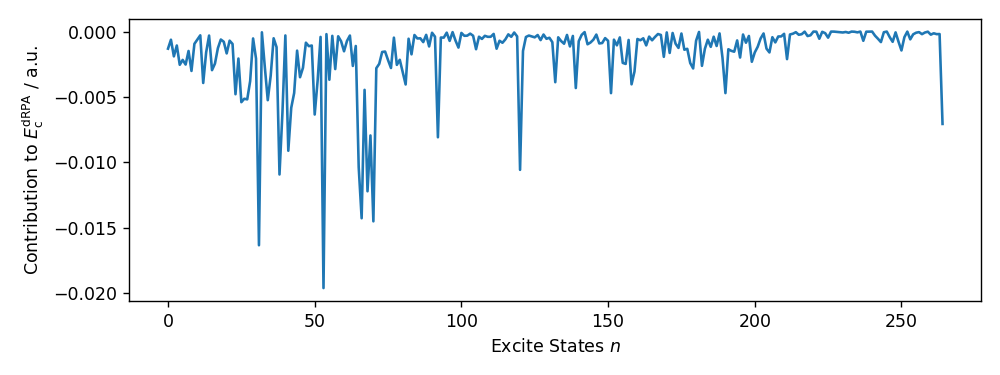

In [15]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(np.arange(nvir * nocc), 0.5 * (mf_dRPA.e - mf_dTDA.e))
ax.set_xlabel("Excite States $n$")
ax.set_ylabel("Contribution to $E^\mathsf{dRPA}_\mathrm{c}$ / a.u.")
fig.tight_layout()

从这张图上，尽管能看到前若干个态的相关能贡献较大，但并不能简单地认为后几个态的贡献较小以至于能忽略。因此，我们必须计算所有 PySCF 中所定义的 dRPA 与 dTDA 激发能，才能得到相对来说精确的总 dRPA 相关矫正能。

### PySCF 的 dRPA 与 dTDA 激发能

在 PySCF 中，dRPA 能量是通过下述方程获得。首先，我们定义 dRPA 的激发与退激发张量：

$$
\begin{align}
A_{ia, jb}^\mathsf{dRPA} &= - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab} + 2 (ia|jb) \\
B_{ia, jb}^\mathsf{dRPA} &= 2 (ia|jb) \tag{2}
\end{align}
$$

随后求解下述本征问题：

$$
\begin{equation}
\begin{pmatrix} \mathbf{A}^\mathsf{dRPA} & \mathbf{B}^\mathsf{dRPA} \\ - \mathbf{B}^\mathsf{dRPA} & - \mathbf{A}^\mathsf{dRPA} \end{pmatrix}
\begin{pmatrix} \mathbf{X}_n \\ \mathbf{Y}_n \end{pmatrix}
= \pm \omega_n^\mathsf{dRPA} \begin{pmatrix} \mathbf{X}_n \\ \mathbf{Y}_n \end{pmatrix} \tag{3}
\end{equation}
$$

我们首先定义 dRPA 的 `A_dRPA` $A_{ia, jb}^\mathsf{dRPA}$ 与 `B_dRPA` $B_{ia, jb}^\mathsf{dRPA}$，它们尽管是以张量形式定义，但实际计算时使用 $(n_\mathrm{occ} n_\mathrm{vir}, n_\mathrm{occ} n_\mathrm{vir})$ 维度的矩阵来表达。

In [16]:
delta_ij, delta_ab = np.eye(nocc), np.eye(nvir)
A_dRPA = (
    np.einsum("ia, ij, ab -> iajb", - eo[:, None] + ev[None, :], delta_ij, delta_ab)
    + 2 * eri0_iajb)
B_dRPA = 2 * eri0_iajb
A_dRPA, B_dRPA = A_dRPA.reshape(nocc*nvir, nocc*nvir), B_dRPA.reshape(nocc*nvir, nocc*nvir)

该本征问题会求出正负对应的激发能。我们只需要求取其正激发能 $\omega_n^\mathsf{dRPA}$ 部分即可。

In [17]:
AB_dRPA = np.block([
    [ A_dRPA,  B_dRPA],
    [-B_dRPA, -A_dRPA],
])

计算得到的激发能将从小到大储存到 `e_dRPA` 中。

In [18]:
e_dRPA = np.linalg.eig(AB_dRPA)[0]
e_dRPA.sort()
e_dRPA = e_dRPA[nocc*nvir:]

该激发能可以与 PySCF 所的到的激发能对照：

In [19]:
np.allclose(e_dRPA, mf_dRPA.e)

True

同样地，对 dTDA 激发也能作相应的验证。与 dRPA 激发的区别在于激发与退激发张量构造上有所不同：

$$
\begin{align}
A_{ia, jb}^\mathsf{dTDA} &= - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab} + 2 (ia|jb) = A_{ia, jb}^\mathsf{dRPA} \\
B_{ia, jb}^\mathsf{dTDA} &= 0
\end{align}
$$

尽管其本征问题从构造上与 dRPA 激发可以一致，但也可以简化为

$$
\begin{equation}
\mathbf{A}^\mathsf{dTDA} \mathbf{X}_n = \omega^\mathsf{dTDA}_n \mathbf{X}_n \tag{4}
\end{equation}
$$

In [20]:
A_dTDA = A_dRPA
e_dTDA = np.linalg.eig(A_dRPA)[0]
e_dTDA.sort()

In [21]:
np.allclose(e_dTDA, mf_dTDA.e)

True

## 程序实现：$O(N^6)$ 直接实现方式

### 程序实现

从公式表达上，类似 TD-KS 方程的解并不是比较方便的写法。一种比较早期的实现方式在 <cite data-cite="Furche-Furche.PRB.2001.64">Furche PRB 2001</cite> 的文章中提及，但比较友好的表达公式在 <cite data-cite="Eshuis-Furche.TCA.2012.131">Eshuis TCA 2012</cite> (eq.76) 有所提及。其实现方式是

$$
\begin{align}
\mathbf{M} &= (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA})^{1/2} (\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA})^{1/2} \\
E^\mathsf{dRPA}_\mathrm{c} &= \frac{1}{2} \mathrm{tr} (\mathbf{M}^{1/2} - \mathbf{A}^\mathsf{dTDA}) \tag{5}
\end{align}
$$

其程序实现也非常方便。

In [22]:
AmB_1p2 = fractional_matrix_power(A_dRPA - B_dRPA, 0.5)
M = AmB_1p2 @ (A_dRPA + B_dRPA) @ AmB_1p2
eng_dRPA_direct = 0.5 * np.trace(fractional_matrix_power(M, 0.5) - A_dTDA)
eng_dRPA_direct

-0.4313792211663592

之所以说是 $O(N^6)$ 计算复杂度，是因为其中使用到了矩阵的分数幂次与乘积；而矩阵的长与宽都是 $n_\mathrm{occ} n_\mathrm{vir}$，因此其计算量复杂度是 $O(n_\mathrm{occ}^3 n_\mathrm{vir}^3)$ 的。

### 与类 TD-KS 实现等价性的数学说明

首先，我们作一些线性代数的基础知识补充。我们先定义两个 5 维度任意张量 `X`, `Y` $\mathbf{X}, \mathbf{Y}$，来表述问题。

In [23]:
np.random.seed(0)
X = np.random.randn(5, 5)
Y = np.random.randn(5, 5)

**(1)** 矩阵迹的和可以直接作拆分：

$$
\mathrm{tr} (\mathbf{X} + \mathbf{Y}) = \mathrm{tr} (\mathbf{X}) + \mathrm{tr} (\mathbf{Y})
$$

In [24]:
np.allclose((X + Y).trace(), X.trace() + Y.trace())

True

**(2)** 交换律：

$$
\mathrm{tr} (\mathbf{X} \mathbf{Y}) = \mathrm{tr} (\mathbf{Y} \mathbf{X})
$$

In [25]:
np.allclose((X @ Y).trace(), (Y @ X).trace())

True

**(2)** 矩阵的迹等于其本征值的和：

$$
\begin{align}
\mathbf{X} \boldsymbol{f}_n &= \omega_n \boldsymbol{f}_n \\
\mathrm{tr} (\mathbf{X}) &= \sum_n \omega_n
\end{align}
$$

In [26]:
eig, F = np.linalg.eig(X)
np.allclose(X.trace(), eig.sum())

True

说明如下。如果我们定义矩阵 `F` $\mathbf{F}$ 为列向量 $\{ \boldsymbol{f}_n \}$ 的并，以及 `O` $\mathbf{\Omega}$ 是以本征值 `w` $\{ \omega_n \}$ 为对角元的对角矩阵，那么

$$
\mathbf{X} \mathbf{F} = \mathbf{F} \mathbf{\Omega}
$$

In [27]:
O = np.diag(eig)
np.allclose(X @ F, F @ O)

True

因此，

$$
\sum_n \omega_n \equiv \sum_n \Omega_{nn} = \mathrm{tr} (\mathbf{\Omega}) = \mathrm{tr} (\mathbf{F}^{-1} \mathbf{X} \mathbf{F}) = \mathrm{tr} (\mathbf{F}^{-1} \mathbf{F} \mathbf{X}) = \mathrm{tr} (\mathbf{X})
$$

有上述的基础知识后，我们可以说明式 (5) 的 $O(N^6)$ 的公式表达与式 (1) 的类 TD-KS 方程实现是等价的。

**(a)** $\omega_n^\mathsf{dRPA}$

我们先回顾式 (3) 所导出的 dRPA 激发能：

$$
\begin{pmatrix} \mathbf{A}^\mathsf{dRPA} & \mathbf{B}^\mathsf{dRPA} \\ - \mathbf{B}^\mathsf{dRPA} & - \mathbf{A}^\mathsf{dRPA} \end{pmatrix}
\begin{pmatrix} \mathbf{X}_n \\ \mathbf{Y}_n \end{pmatrix}
= \pm \omega_n^\mathsf{dRPA} \begin{pmatrix} \mathbf{X}_n \\ \mathbf{Y}_n \end{pmatrix}
$$

从矩阵转换为方程则表达为 (我们只考虑正激发能结果，因此去除上式的正负号 $\pm$)：

$$
\begin{align}
\mathbf{A}^\mathsf{dRPA} \mathbf{X}_n + \mathbf{B}^\mathsf{dRPA} \mathbf{Y}_n &= \omega_n^\mathsf{dRPA} \mathbf{X}_n \\
\mathbf{B}^\mathsf{dRPA} \mathbf{X}_n + \mathbf{A}^\mathsf{dRPA} \mathbf{Y}_n &= - \omega_n^\mathsf{dRPA} \mathbf{Y}_n
\end{align}
$$

将上两式作加减法，得到

$$
\begin{align}
(\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{X}_n + \mathbf{Y}_n) &= \omega_n^\mathsf{dRPA} (\mathbf{X}_n - \mathbf{Y}_n) \\
(\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA}) (\mathbf{X}_n - \mathbf{Y}_n) &= \omega_n^\mathsf{dRPA} (\mathbf{X}_n + \mathbf{Y}_n)
\end{align}
$$

将上两式左右相乘，可以得到

$$
\big( (\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA}) \big) (\mathbf{X}_n^2 - \mathbf{Y}_n^2) = (\omega_n^\mathsf{dRPA})^2 (\mathbf{X}_n^2 - \mathbf{Y}_n^2)
$$

对上式左右开根号，得到

$$
\big( (\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA}) \big)^{1/2} (\mathbf{X}_n^2 - \mathbf{Y}_n^2)^{1/2} = \omega_n^\mathsf{dRPA} (\mathbf{X}_n^2 - \mathbf{Y}_n^2)^{1/2}
$$

由于矩阵的迹等于其本征值的和，因此

$$
\begin{align}
\sum_{n} \omega_n^\mathsf{dRPA} &= \mathrm{tr} \big[ \big( (\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA}) \big)^{1/2} \big] \\
&= \mathrm{tr} \big[ \big( (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA})^{1/2} (\mathbf{A}^\mathsf{dRPA} + \mathbf{B}^\mathsf{dRPA}) (\mathbf{A}^\mathsf{dRPA} - \mathbf{B}^\mathsf{dRPA})^{1/2} \big)^{1/2} \big] \\
&\equiv \mathrm{tr} (\mathbf{M}^{1/2})
\end{align}
$$

**(2)** $\omega^\mathsf{dTDA}_n$

回顾式 (5) 所导出的 dTDA 激发能：

$$
\mathbf{A}^\mathsf{dTDA} \mathbf{X}_n = \omega^\mathsf{dTDA}_n \mathbf{X}_n
$$

我们能立即利用矩阵的迹等于其本征值的和，得到

$$
\sum_n \omega^\mathsf{dTDA}_n = \mathrm{tr} (\mathbf{A}^\mathsf{dTDA})
$$

总结上述的结果，可以得到

$$
E^\mathsf{dRPA}_\mathrm{c} = \frac{1}{2} \sum_n (\omega_n^\mathsf{dRPA} - \omega_n^\mathsf{dTDA}) = \frac{1}{2} \big( \mathrm{tr} (\mathbf{M}^{1/2}) - \mathrm{tr} (\mathbf{A}^\mathsf{dTDA}) \big) = \frac{1}{2} \mathrm{tr} (\mathbf{M}^{1/2} - \mathbf{A}^\mathsf{dTDA})
$$

## 简单理解 dRPA 相关能 (1)：绝热路径与密度涨落

这里我们主要使用 <cite data-cite="Eshuis-Furche.TCA.2012.131">Eshuis TCA 2012</cite> 的文章的思路来叙述；但这一段本身是 DFT 理论的基础，因此不仅是 dRPA，其它类型的相关能 (GGA, Hybrid, Double Hybrid) 都可以用下述框架作为基础推导。

这里并非是对 DFT 理论的回顾，而是在对 DFT 理论有基础了解之后的一些补充理解。

我们之后会提及，dRPA 具有两种解释方法。一种为类 TD-KS 方法，另一种为涨落耗散定理。从实现上，我们已经对类 TD-KS 方法做了说明。我们以后还会对涨落耗散定理的方法的实现作说明，并且会对这两种方法作推导。尽管这两种方法在公式表达上有巨大的差别，但结果相同；且其推导前提都是绝热路径与密度涨落。

这一段完全是理论性的，不包含任何程序，也不包含任何近似 (除了 Kohn-Sham 图景本身或 Levy Constrained Search 之外)。

### 绝热路径 (1)：定义

关于绝热路径，较为基础但清晰的综述是 <cite data-cite="Perdew-Kurth.Springer.2003">Perdew 2003</cite> (p.16)。我们首先定义关于变量 $\alpha$ 的电子态波函数哈密顿算符 (不包含核互斥部分) (后文中的 $\alpha$ 一般都不指代向上自旋的含义)

$$
\hat H^\alpha = \hat T + \alpha \hat V_\mathrm{ee} + \hat V_\mathrm{ext} + \hat V^\alpha
$$

其中，$\hat T$ 为动能算符，$\hat V_\mathrm{ee}$ 为电子互斥算符 (下两式的 $i$ 暂时代表电子角标而非占据轨道)，$\hat V_\mathrm{ext}$ 在无外场的情况下定义为电子与原子互斥势算符 ($A$ 代表原子角标)：

$$
\begin{align}
\hat T &= - \frac{1}{2} \sum_{i} \nabla_{\boldsymbol{r}_i}^2 \\
\hat V_\mathrm{ee} &= \frac{1}{2} \sum_{i \neq j} \frac{1}{| \boldsymbol{r}_i - \boldsymbol{r}_j |} \\
\hat V_\mathrm{exc} &= \sum_i v_\mathrm{exc} (\boldsymbol{r}_i) = - \sum_{Ai} \frac{Z_A}{| \boldsymbol{r}_i - \boldsymbol{r}_A |}
\end{align}
$$

而第三个算符 $\hat V^\alpha$ 定义如下。若 $\alpha = 1$，则定义为零。这种情况下，$\hat H^{\alpha = 1}$ 恰好是精确的电子态哈密顿算符 $\hat T + \hat V_\mathrm{ee} + \hat V_\mathrm{ext}$；而若 $\alpha = 0$，在 DFT 下则是需要被定义的量，各种 DFT 的近似的目标也是希望描述清楚 $\hat V_\mathrm{xc}$；在我们的实际计算中，$\alpha = 0$ 的情况对应 PBE 参考态的计算。

即定义为交换相关势相关量。这对应的是 Kohn-Sham 电子态哈密顿算符，且不包含交换部分。我们之前计算所用到的 PBE，或者 BLYP, SVWN5 等即可以看作对该算符 $\hat V^{\alpha = 0}$ 的近似；但 B3LYP 则包含 0.2 份了交换，因此近似的对象不是 $\hat V^{\alpha = 0}$ (近似对象很接近 $\hat V^{\alpha = 0.2}$，但严格来说并非如此，因为 $0.2 \hat V_\mathrm{ee}$ 本质是双电子算符，因此其精确求解还是与 $\alpha = 1$ 的情形没有本质区别，而不可能是杂化 DFT 近似的做法)，也因此不再这篇文档的讨论范畴中。

若 Kohn-Sham 图景下可以构造出完全精确的交换相关势，那么 $\hat H^{\alpha = 0}$ 即使与 $\hat V^{\alpha = 1}$ 具有不同的形式，导出不同的波函数

$$
\begin{align}
\hat H^{\alpha = 1} | \hat \Psi^{\alpha = 1} \rangle &= E_\mathrm{elec} | \hat \Psi^{\alpha = 1} \rangle \\
\hat H^{\alpha = 0} | \hat \Psi^{\alpha = 0} \rangle &= E_\mathrm{elec} | \hat \Psi^{\alpha = 0} \rangle
\end{align}
$$

其中，$E_\mathrm{elec}$ 是基态能量。

之所以要这么绕弯子，是因为我们无法在较少计算量下得到真实的电子态波函数。从程序实现的角度讲，在 Kohn-Sham 图景下，假设真实的电子态密度 $\rho = \langle \Psi^{\alpha = 1} | \hat \rho | \Psi^{\alpha = 1} \rangle$ 能够通过相互正交的、电子数量的关于电子坐标 $\boldsymbol{r}$ 的函数 $\phi_{i} (\boldsymbol{r})$ 之和表示：$\rho = \langle \Psi^{\alpha = 0} | \hat \rho | \Psi^{\alpha = 0} \rangle$。那么就存在势函数 $v^\mathrm{xc} (\boldsymbol{r}_i)$，使得 $\hat H^{\alpha = 0} | \hat \Psi^{\alpha = 0} \rangle$ 波函数的求解可以通过类似于 Hartree-Fock 的自洽场过程给出而不需要进行大计算量的 Post-HF 过程，但在这些有限的计算量下给出正确的密度。

基于上述的定义，我们可以给出波函数 $| \Psi^{\alpha} \rangle$ 关于 $\alpha$ 变量的绝热路径。该“绝热路径”的守恒量是电子态密度，即对于任意 $\alpha$，

$$
\rho = \langle \Psi^\alpha | \hat \rho | \Psi^\alpha \rangle
$$

是完全相等的。

### 绝热路径 (2)：与相关能的联系

DFT 近似的主要目标是给出交换相关能；上述的绝热路径是一种从波函数角度出发一窥交换相关能构造的做法。

首先，总电子态能量 $E_\mathrm{elec}$ (不包含核互斥能) 可以拆分为单电子轨道动能 $T_\mathrm{s} [\rho]$、外势能 $V_\mathrm{ext} [\rho]$、库伦积分 $J [\rho]$：

$$
\begin{align}
T_\mathrm{s} [\rho] &= \langle \Psi^{\alpha = 0} | \hat T | \Psi^{\alpha = 0} \rangle \\
V_\mathrm{ext} [\rho] &= \int \rho(\boldsymbol{r}) v_\mathrm{ext} (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r} \\
U [\rho] &= \frac{1}{2} \iint \frac{\rho(\boldsymbol{r}) \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'
\end{align}
$$

上述三式是比较容易求取的。除此之外，定义交换能为

$$
E_\mathrm{x} [\rho] = \langle \Psi^{\alpha = 0} | \hat V_\mathrm{ee} | \Psi^{\alpha = 0} \rangle - U[\rho]
$$

交换能可以通过类似与 Hartree-Fock 的方法给出。因此，上述四项都是程序容易实现，且应当仅与密度有关。

下面我们就要给出相关能的表达式。它可以定义为

$$
\begin{align}
E_\mathrm{c} [\rho] &= E_\mathrm{elec} [\rho] - \langle \Psi^{\alpha = 0} | \hat H^{\alpha = 1} | \Psi^{\alpha = 0} \rangle \\
&= \langle \Psi^{\alpha = 0} | \hat H^{\alpha = 0} | \Psi^{\alpha = 0} \rangle - \langle \Psi^{\alpha = 0} | \hat H^{\alpha = 1} | \Psi^{\alpha = 0} \rangle \\
&= \langle \Psi^{\alpha = 0} | \hat V_\mathrm{xc} | \Psi^{\alpha = 0} \rangle - E_\mathrm{x} [\rho] \tag{6}
\end{align}
$$

也可以定义为

$$
\begin{align}
E_\mathrm{c} [\rho] &= \langle \Psi^{\alpha = 1} | \hat H^{\alpha = 1} | \Psi^{\alpha = 1} \rangle - \langle \Psi^{\alpha = 0} | \hat H^{\alpha = 1} | \Psi^{\alpha = 0} \rangle \\
&= \langle \Psi^{\alpha = 1} | \hat T + \hat V_\mathrm{ee} | \Psi^{\alpha = 1} \rangle - T_\mathrm{s} [\rho] - U[\rho] - E_\mathrm{x} [\rho] \\
&= \langle \Psi^{\alpha = 1} | \hat T + \hat V_\mathrm{ee} | \Psi^{\alpha = 1} \rangle - \langle \Psi^{\alpha = 0} | \hat T | \Psi^{\alpha = 0} \rangle - \langle \Psi^{\alpha=0} | \hat V_\mathrm{ee} | \Psi^{\alpha=0} \rangle \tag{7}
\end{align}
$$

上式的前两项可以看作是关于 $\alpha$ 定积分的上下界，因此上式也可以表达为

$$
E_\mathrm{c} [\rho] = \int_0^1 \frac{\mathrm{d}}{\mathrm{d} \alpha} \langle \Psi^{\alpha} | \hat T + \alpha \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle \, \mathrm{d} \alpha - \langle \Psi^{\alpha=0} | \hat V_\mathrm{ee} | \Psi^{\alpha=0} \rangle
$$

根据 (变分情形而非本征情形的) Hellmann-Feynman 定理，有

$$
\begin{align}
E_\mathrm{c} [\rho]
&= \int_0^1 \frac{\mathrm{d}}{\mathrm{d} \alpha} \langle \Psi^{\alpha} | \alpha \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle \, \mathrm{d} \alpha - \langle \Psi^{\alpha=0} | \hat V_\mathrm{ee} | \Psi^{\alpha=0} \rangle \\
&= \int_0^1 \langle \Psi^{\alpha} | \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle \, \mathrm{d} \alpha - U[\rho] - E_\mathrm{x} [\rho] \tag{8}
\end{align}
$$

式 (6) 是 Kohn-Sham 方式下最直观的交换能定义；它不包含真实波函数 $| \Psi^{\alpha = 1} \rangle$ 的信息，但有目前只能依靠近似才能获得的 $\hat V_\mathrm{xc}$ 算符。式 (7) 或 (8) 则不包含 $\hat V_\mathrm{xc}$，但具有 $| \Psi^{\alpha = 1} \rangle$。我们或许会认为后者的公式包含的已知或可知信息更多一些 (获取 $| \Psi^{\alpha = 1} \rangle$ 计算量巨大的，避免获取之也是 DFT 近似的发展动力，但它在小体系有限基组下仍然是可求得的，并且更容易进行后自洽行为的分析)，因此我们将着重对式 (8) 进行考察。

### 二次量子化 (1)：$\hat V_\mathrm{ee}$ 与 $\hat \rho (\boldsymbol{r})$ 的定义

这里我们参考 <cite data-cite="Helgaker-Jorgensen.Wiley.2013">Helgaker Wiley 2013</cite> 的说明。由于我们推导的是闭壳层的情形，因此我们需要引入单重激发算符 (仅在下式中的 $\alpha$ 代表自旋的含义)

$$
\hat E_{pq} = a_{p \alpha}^\dagger a_{q \alpha} + a_{p \beta}^\dagger a_{q \beta}
$$

这里规定，当 $a$ 字母不在角标处时，则表示产生或湮灭算符。由此出发，我们能定义双电子算符 (Helgaker, eq 2.2.15)：

$$
\hat V_\mathrm{ee} = \frac{1}{2} \sum_{\sigma, \sigma'} \sum_{pq, rs} (pq|rs) a_{p \sigma}^\dagger a_{r \sigma}^\dagger a_{s \sigma'} a_{q \sigma'} = \frac{1}{2} \sum_{pq, rs} (pq|rs) (\hat E_{pq} \hat E_{rs} - \delta_{pr} \hat E_{qs})
$$

随后，我们定义密度算符 $\hat \rho(\boldsymbol{r})$ (Eshuis, eq 11) (需要留意，Helgaker 的算符定义应都出于程序实现的要求，不会出现关于坐标呈变值的算符)：

$$
\hat \rho (\boldsymbol{r}) = \sum_{pq} \hat E_{pq} \phi_p (\boldsymbol{r}) \phi_q (\boldsymbol{r})
$$

其中，$\phi_p (\boldsymbol{r})$ 表示轨道 $p$ 的分子轨道函数。这里的分子轨道指代的是作为 $\alpha = 0$ 参考态的轨道。容易知道密度算符具有下述性质：

$$
\rho (\boldsymbol{r}) = \langle \Psi^{\alpha} | \hat \rho(\boldsymbol{r}) | \Psi^{\alpha} \rangle
$$

但需要注意到，下述不等号一般情况下是成立的：

$$
\rho (\boldsymbol{r}) \rho (\boldsymbol{r}') \neq \langle \Psi^{\alpha} | \hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}') | \Psi^{\alpha} \rangle
$$

我们或许还需要定义双坐标密度算符 $\hat \rho (\boldsymbol{r}, \boldsymbol{r}')$：

$$
\hat \rho (\boldsymbol{r}, \boldsymbol{r}') = \sum_{pq} \hat E_{pq} \phi_p (\boldsymbol{r}) \phi_q (\boldsymbol{r}')
$$

以及 delta 算符 $\hat \delta (\boldsymbol{r}, \boldsymbol{r}')$，注意到下述定义与 Dirac Delta 函数应当是等价的：

$$
\hat \delta (\boldsymbol{r}, \boldsymbol{r}') = \sum_{pq} \delta_{pq} \phi_p (\boldsymbol{r}) \phi_q (\boldsymbol{r}') = \delta (\boldsymbol{r} - \boldsymbol{r}')
$$

因此，我们可以重述算符 $\hat V_\mathrm{ee}$ 为

$$
\begin{align}
\hat V_\mathrm{ee} &= \frac{1}{2} \iint \frac{\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}') - \hat \delta (\boldsymbol{r}, \boldsymbol{r}') \hat \rho(\boldsymbol{r}, \boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' \\
&= \frac{1}{2} \iint \frac{\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}') - \delta(\boldsymbol{r} - \boldsymbol{r}') \hat \rho(\boldsymbol{r})}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'
\end{align}
$$

上述等式中或许存在一项非常特殊的表达式：

$$
\hat V_\mathrm{ee} \leftarrow
- \frac{1}{2} \iint \frac{\delta(\boldsymbol{r} - \boldsymbol{r}') \hat \rho(\boldsymbol{r})}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' = - \frac{1}{2} \int \frac{\hat \rho(\boldsymbol{r})}{0} \, \mathrm{d} \boldsymbol{r} = \mathrm{NaN}
$$

这项中，无论左乘右乘何种波函数，$\hat \rho (\boldsymbol{r})$ 具体表达式如何，其结果一定为非数 (NaN, Not a Number)。如果将 $\delta$ 函数当作一种逼近极限的话，应当认为上述值比起 NaN 来说更接近 $- \infty$。

显然，我们知道 $\langle \Psi^{\alpha} | \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle$ 是有界的，且在 $\alpha = 0$ 时代表库伦积分与交换能之和。但上述分项为 NaN，那么一定也就意味着

$$
\hat V_\mathrm{ee} \leftarrow
- \frac{1}{2} \iint \frac{\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' = \mathrm{NaN}
$$

### 二次量子化 (2)：密度涨落算符 $\Delta \hat \rho (\boldsymbol{r})$

随后我们引入密度涨落算符

$$
\Delta \hat \rho(\boldsymbol{r}) = \hat \rho(\boldsymbol{r}) - \rho(\boldsymbol{r})
$$

密度涨落算符并不是一定要引入的算符；这我们会在后面一段推导时会提及。类似地，我们也能了解到性质

$$
0 = \langle \Psi^{\alpha} | \Delta \hat \rho(\boldsymbol{r}) | \Psi^{\alpha} \rangle
$$

将密度涨落算符的定义代入，我们还可以重述算符 $\hat V_\mathrm{ee}$ 为

$$
\begin{align}
\hat V_\mathrm{ee} &=
\frac{1}{2} \iint \frac{\Delta \hat \rho(\boldsymbol{r}) \Delta \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' \\
&\quad + \frac{1}{2} \iint \frac{\Delta \hat \rho(\boldsymbol{r}) \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'
+ \frac{1}{2} \iint \frac{\rho(\boldsymbol{r}) \Delta \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' \\
&\quad - \frac{1}{2} \iint \frac{\delta(\boldsymbol{r} - \boldsymbol{r}') \hat \rho(\boldsymbol{r})}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'
+ U[\rho]
\end{align}
$$

我们在这里指出，由于后四个贡献项都仅与单个密度算符、或密度涨落算符有关，因此在左乘 $\langle \Psi^{\alpha} |$ 右乘 $| \Psi^{\alpha} \rangle$ 后，不论 $\alpha$ 的值是多少，其结果都应当相等 (因为对任意 $\alpha$ 的 $| \Psi^{\alpha} \rangle$，其密度相等)。举其中一个例子而言，

$$
\frac{1}{2} \langle \Psi^\alpha | \iint \frac{\Delta \hat \rho(\boldsymbol{r}) \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' | \Psi^\alpha \rangle
= \iint \frac{\rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \langle \Psi^\alpha | \Delta \hat \rho(\boldsymbol{r}) | \Psi^\alpha \rangle  \, \mathrm{d} \boldsymbol{r}\, \mathrm{d} \boldsymbol{r}'
= 0
$$

之所以上式中对 $\boldsymbol{r}, \boldsymbol{r}'$ 的积分，与左右矢符号可以交换，是借了二次量子化算符 $a_p^\dagger, a_p$ 等算符与电子坐标 $\boldsymbol{r}$ 无关的便利。因此，能真正区别不同波函数的算符贡献项，只有上式中的第一项。

根据上述说明，我们可以对绝热路径与相关能的关联式 (8) 重新写为

$$
\begin{align}
E_\mathrm{c} [\rho]
&= \int_0^1 \langle \Psi^{\alpha} | \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle \, \mathrm{d} \alpha - \langle \Psi^{\alpha=0} | \hat V_\mathrm{ee} | \Psi^{\alpha=0} \rangle \\
&= \int_0^1 \big( \langle \Psi^{\alpha} | \hat V_\mathrm{ee} | \Psi^{\alpha} \rangle - \langle \Psi^{\alpha=0} | \hat V_\mathrm{ee} | \Psi^{\alpha=0} \rangle \big) \, \mathrm{d} \alpha \\
&= \frac{1}{2} \int_0^1 \, \mathrm{d} \alpha \iint \, \mathrm{d} \boldsymbol{r}\, \mathrm{d} \boldsymbol{r}' \frac{\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle - \langle \Psi^{\alpha=0} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha=0} \rangle}{| \boldsymbol{r} - \boldsymbol{r}' |} \tag{9}
\end{align}
$$

### 幺元分解：建立相关能与激发态的联系

在波函数空间下，我们将所有满足定态方程

$$
\hat H^\alpha | \Psi_n^\alpha \rangle = (E_\mathrm{elec} + \omega_n^\alpha) | \Psi_n^\alpha \rangle
$$

的波函数 $| \Psi_n^\alpha \rangle$ 归并在一起 $\{ | \Psi_n^\alpha \rangle \}$；该解空间与 $\{ | \Psi^\alpha \rangle \}$ 的并集假定认为是完备的。其中，$\omega_n^\alpha$ 称作在绝热路径 $\alpha$ 基态波函数上的第 $n$ 个激发态的激发能量。我们不把基态列入 $n$ 的角标范围中，或者说 $n$ 不能取到 0；这种记号可能有别于一些文章。

定义了上述记号并作完备性的假定后，尽管不很严谨，但我们指出存在下述幺元分解 (RI, Resolution of Identity)：

$$
| \Psi^\alpha \rangle \langle \Psi^\alpha | + \sum_{n} | \Psi_n^\alpha \rangle \langle \Psi_n^\alpha | = 1
$$

因此，我们可以将式 (9) 中的一部分分项写作

$$
\begin{align}
\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle
&= \langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) | \Psi^\alpha \rangle \langle \Psi^\alpha | \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle + \sum_n \langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) | \Psi_n^\alpha \rangle \langle \Psi_n^\alpha | \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle \\
&= \sum_{n} \langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) | \Psi_n^\alpha \rangle \langle \Psi_n^\alpha | \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle
\end{align}
$$

上式的第二个等号利用的是基态波函数的 $\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) | \Psi^\alpha \rangle = 0$。这样，我们就将相关能与激发态之间建立了联系。我们也会记跃迁密度为

$$
\rho_{0n}^\mathrm{\alpha} (\boldsymbol{r}) = \langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) | \Psi_n^\alpha \rangle = \langle \Psi^{\alpha} | \hat \rho (\boldsymbol{r}) | \Psi_n^\alpha \rangle 
$$

之所以说“完备性”是假定，是因为并不是所有激发态都被囊括了进来；譬如三重态激发在推导与程序中就不在其中。当然，我们考虑一般的跃迁密度时，单重到三重的激发是禁阻的，因此三重激发也不需要出现在幺元分解式中。因此，这种“完备性”尽管一点都不完备，但基本是够用的。

事实上，从上式中能看出，由于在描述基态到激发态的跃迁过程时，$\Delta \hat \rho (\boldsymbol{r})$ 与 $\hat \rho (\boldsymbol{r})$ 没有本质区别，因此会说额外定义密度涨落算符不一定非常实际的意义；当然，用涨落算符会在公式中更加凸显相关能与密度波动之间的联系。

最后，我们需要指出，单看下式的话，

$$
\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle = \mathrm{NaN}
$$

如果从跃迁密度的角度讲，上式相当于对所有激发态的跃迁密度平方的求和：

$$
\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle = \sum_{n} \rho_{0n}^{\alpha} (\boldsymbol{r}) \rho_{0n}^{\alpha, \dagger} (\boldsymbol{r}')
$$

上式的 $\dagger$ 表示的是复共轭。显然，每个激发态相对于基态密度的扰动都是比较大的，因此每个跃迁密度本身不可能是无穷小量；加之激发态数量无限，因此上述求和也是无限的，不可能是有界量。(当然，对于有限基组而言这显然是有界量)

而如果从 $\hat V_\mathrm{ee}$ 的拆分角度来讲也是同样的。我们之前指出过，

$$
\hat V_\mathrm{ee} \leftarrow
- \frac{1}{2} \iint \frac{\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' = \mathrm{NaN}
$$

只需要一些简单的分析，应当不难知道

$$
\frac{1}{2} \langle \Psi^\alpha | \iint \frac{\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' | \Psi^\alpha \rangle
= \frac{1}{2} \langle \Psi^\alpha | \iint \frac{\Delta \hat \rho(\boldsymbol{r}) \Delta \hat \rho(\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}' | \Psi^\alpha \rangle + U[\rho]
$$

因此我们应当预期 $\Delta \hat \rho(\boldsymbol{r}) \Delta \hat \rho(\boldsymbol{r}')$ 与 $\hat \rho(\boldsymbol{r}) \hat \rho(\boldsymbol{r}')$ 具有比较接近的性质。

因此，单就讨论 $\langle \Psi^{\alpha} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha} \rangle$ 本身是不能得到结论的，而需要与 $\langle \Psi^{\alpha = 0} | \Delta \hat \rho (\boldsymbol{r}) \Delta \hat \rho (\boldsymbol{r}') | \Psi^{\alpha = 0} \rangle$ 相减才能得到有界的相关能。最后指出，我们可以将相关能式 (9) 写作

$$
\begin{align}
E_\mathrm{c} [\rho]
&= \frac{1}{2} \int_0^1 \, \mathrm{d} \alpha \iint \, \mathrm{d} \boldsymbol{r}\, \mathrm{d} \boldsymbol{r}' \left( \sum_{n} \frac{\rho_{0n}^{\alpha} (\boldsymbol{r}) \rho_{0n}^{\alpha, \dagger} (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} - \sum_{n} \frac{\rho_{0n}^{\alpha=0} (\boldsymbol{r}) \rho_{0n}^{\alpha=0, \dagger} (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \right) \tag{10}
\end{align}
$$

从程序实现来说，跃迁密度不会是非实数量，因此共轭记号 $\dagger$ 一般是可以去掉的。

## 简单理解 dRPA 相关能 (2)：类 TD-KS 方法

dRPA 相关能的推导一般可以有三种方式，为类 TD-KS (Time-Dependent Kohn-Sham) 方法、涨落耗散理论 (Fluctuation Dissipation Theory)、以及格林函数 (GW, Green's Wavefunction) 途径。在这篇文档中，我们只讨论前两种方法；他们的共同基础是上面的绝热路径与密度涨落。通过密度涨落，我们建立了相关能与激发态的联系。

激发态很容易地与 TD-KS 方法产生直观的联系。我们下面就会讨论如何从 TD-KS 近似得到 dRPA 相关能。我们仍然按照 <cite data-cite="Eshuis-Furche.TCA.2012.131">Eshuis TCA 2012</cite> 的思路来理解。

### TD Hartree 近似与跃迁密度的联系

在这里我们不陈述 TD-KS 方程是如何推导的，只说明结论。

首先，如前所述，dRPA 相关能的交换部分是通过精确交换能表达式给出的；因此之后我们的讨论中就不引入交换能。我们考察的波函数 $| \Psi^{\alpha = 0} \rangle$ 作为仅包含单电子算符贡献的 Kohn-Sham 等效哈密顿算符 $\hat H^{\alpha = 0}$ 的本征态，其形式并不取用 Slater 行列式，而令其为 Hartree 连乘积。

对于波函数 $| \Psi^{\alpha = 0} \rangle$，其 TD-KS 方程 (Casida 方程) 列为

$$
\begin{equation}
\begin{pmatrix} \mathbf{A}^\alpha & \mathbf{B}^\alpha \\ - \mathbf{B}^\alpha & - \mathbf{A}^\alpha \end{pmatrix}
\begin{pmatrix} \mathbf{X}_n^\alpha \\ \mathbf{Y}_n^\alpha \end{pmatrix}
= \pm \omega_n^\alpha \begin{pmatrix} \mathbf{X}_n^\alpha \\ \mathbf{Y}_n^\alpha \end{pmatrix} \tag{11}
\end{equation}
$$

其中，

$$
\begin{align}
A_{ia, jb}^\alpha &= - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab} + 2 \alpha (ia|jb) + f^{\mathrm{xc}, \alpha}_{ia, jb} \\
B_{ia, jb}^\alpha &= 2 \alpha (ia|jb) + f^{\mathrm{xc}, \alpha}_{ia, jb} \tag{12}
\end{align}
$$

如果我们将交换相关能对 TD-KS 方程的贡献全部抹去，那么上式就化为 TD Hartree 的情况：

$$
\begin{align}
A_{ia, jb}^\alpha &\simeq - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab} + 2 \alpha (ia|jb) \\
B_{ia, jb}^\alpha &\simeq 2 \alpha (ia|jb) \tag{13}
\end{align}
$$

尽管这一段大体是公式推导，但我们顺便在此定义一些程序计算用的函数。定义函数 `A` $A_{ia, jb}^\alpha$, `B` $B_{ia, jb}^\alpha$，它们通过输入参数 $\alpha$ 给出张量。

In [28]:
def A(alpha):
    return (np.einsum("ia, ij, ab -> iajb", - eo[:, None] + ev[None, :], delta_ij, delta_ab) + 2 * alpha * eri0_iajb).reshape(nocc*nvir, nocc*nvir)

def B(alpha):
    return (2 * alpha * eri0_iajb).reshape(nocc*nvir, nocc*nvir)

同时，我们定义函数 `omega_list`，通过分别输入 A 与 B 张量对应的 $\alpha$ 值，给出其 TD 方程的正频率列表。

In [29]:
def omega_list(alpha1, alpha2=None):
    alpha2 = alpha2 if alpha2 is not None else alpha1
    A_, B_ = A(alpha1), B(alpha2)
    eig = np.linalg.eig((A_ + B_) @ (A_ - B_))[0]
    eig.sort()
    return np.sqrt(eig)

上述函数能直接计算 dRPA 相关能：

$$
E^\mathsf{dRPA}_\mathrm{c} = \frac{1}{2} \sum_n (\omega_n^\mathsf{dRPA} - \omega_n^\mathsf{dTDA})
$$

我们留意到 dRPA 激发使用的是 $A_{ia, jb}^{\alpha = 1}$, $B_{ia, jb}^{\alpha = 1}$，而 dTDA 激发使用的是 $A_{ia, jb}^{\alpha = 1}$, $B_{ia, jb}^{\alpha = 0}$：

In [30]:
0.5 * (omega_list(1).sum() - omega_list(1, 0).sum())

-0.4313792211675036

我们在这篇文档中不对作为本征向量的 $X_{n, ia}^\alpha$ 与 $Y_{n, ia}^\alpha$ 作程序上的定义，仅作讨论。该本征向量在 PySCF 的程序中作下述归一化定义：

$$
\sum_{ia} \big( (X_{n, ia}^\alpha)^2 - (Y_{n, ia}^\alpha)^2 \big) = \frac{1}{2}
$$

基于上述定义，闭壳层下的 TD 跃迁密度可以定义为 (这也参考 PySCF 的跃迁偶极矩定义)：

$$
\rho_{0n}^\alpha (\boldsymbol{r}) = 2 \sum_{ia} (X_{n, ia}^\alpha + Y_{n, ia}^\alpha) \phi_i (\boldsymbol{r}) \phi_a (\boldsymbol{r})
$$

其中的 2 倍源于闭壳层下的两种自旋贡献之和。

### TD 左右矢定义

在后文中，为了公式推导与表达的便利，这里借用 <cite data-cite="Eshuis-Furche.TCA.2012.131">Eshuis TCA 2012</cite> 中的符号；但需要留意，实际闭壳层程序与原文开壳层的推导在一些细节上有出入。

我们可以定义下述与 TD 方程等价的表达式：

$$
( \mathbf{\Lambda}^\alpha - \omega_n^\alpha \mathbf{\Delta} ) | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle = 0
$$

其中，上式定义

$$
\mathbf{\Lambda}^\alpha = \begin{pmatrix} \mathbf{A}^\alpha & \mathbf{B}^\alpha \\ \mathbf{B}^\alpha & \mathbf{A}^\alpha \end{pmatrix} , \quad
\mathbf{\Delta} = \begin{pmatrix} \mathbf{1} & \mathbf{0} \\ \mathbf{0} & -\mathbf{1} \end{pmatrix}
$$

以及右矢 $| \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle$ 可以看作列向量；相对应地，左矢 $\langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha |$ 可以看作行向量。

经过上述定义，特征向量的归一化条件可以写为

$$
\langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \mathbf{\Delta} | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle = \frac{1}{2}
$$

因此，我们可以从相关能表达式 (10) 出发，写出其中的第一项贡献：

$$
\begin{align}
E_\mathrm{c} [\rho]
&\leftarrow \frac{1}{2} \int_0^1 \, \mathrm{d} \alpha \iint \, \mathrm{d} \boldsymbol{r}\, \mathrm{d} \boldsymbol{r}' \sum_{n} \frac{\rho_{0n}^{\alpha} (\boldsymbol{r}) \rho_{0n}^{\alpha, \dagger} (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \\
&= \frac{1}{2} \cdot 4 \int_0^1 \, \mathrm{d} \alpha \iint \, \mathrm{d} \boldsymbol{r}\, \mathrm{d} \boldsymbol{r}' \sum_{n} (X_{n, ia}^\alpha + Y_{n, ia}^\alpha) \cdot \sum_{ia, jb} \frac{\phi_i (\boldsymbol{r}) \phi_a (\boldsymbol{r}) \phi_j (\boldsymbol{r}') \phi_b (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \cdot (X_{n, jb}^\alpha + Y_{n, jb}^\alpha) \\
&= \frac{1}{2} \cdot 4 \int_0^1 \sum_{n} \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \mathbf{g} \mathbf{I} | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle \, \mathrm{d} \alpha 
\end{align}
$$

其中，我们定义了双电子张量以及分块单位矩阵

$$
g_{ia, jb} = (ia|jb), \quad \mathbf{I} = \begin{pmatrix} \mathbf{1} & \mathbf{1} \\ \mathbf{1} & \mathbf{1} \end{pmatrix}
$$

那么我们会写

$$
\mathbf{g} \mathbf{I} = \begin{pmatrix} \mathbf{g} & \mathbf{g} \\ \mathbf{g} & \mathbf{g} \end{pmatrix}
$$

以及上式的 4 倍是从两个闭壳层跃迁密度的 2 倍系数相乘获得的。

对于式 (10) 的第二项同理。因此，我们可以写

$$
\begin{equation}
E_\mathrm{c} [\rho]
= \frac{1}{2} \cdot 4 \int_0^1 \sum_{n} \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \mathbf{gI} | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle \, \mathrm{d} \alpha
- \frac{1}{2} \cdot 4 \sum_{n} \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \tag{14}
\end{equation}
$$

### TD 方程的 Hellmann-Feynman 定理应用

对于上式 (14)，其第一项中的关于绝热路径参数 $\alpha$ 的积分相对来说比较难处理。但很有意思的是，对 TD 方程应用 Hellmann-Feynman 定理求取关于 $\alpha$ 的母函数，可以解决这个问题。

$$
\begin{align}
0 &= \frac{\mathrm{d}}{\mathrm{d} \alpha} \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | ( \mathbf{\Lambda}^\alpha - \omega_n^\alpha \mathbf{\Delta} ) | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle \\
&= \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \frac{\mathrm{d}}{\mathrm{d} \alpha} ( \mathbf{\Lambda}^\alpha - \omega_n^\alpha \mathbf{\Delta} ) | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle \\
&= \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \frac{\mathrm{d}}{\mathrm{d} \alpha} \mathbf{\Lambda}^\alpha | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle - \frac{1}{2} \frac{\mathrm{d} \omega_n^\alpha}{\mathrm{d} \alpha}
\end{align}
$$

我们之前提到过，在 dRPA 相关能计算中会将 $f^{\mathrm{xc}, \alpha}_{ia, jb}$ 完全近似为零，因此

$$
\frac{\mathrm{d}}{\mathrm{d} \alpha} \mathbf{\Lambda}^\alpha = \frac{\mathrm{d}}{\mathrm{d} \alpha} \begin{pmatrix} \mathbf{A}^\alpha & \mathbf{B}^\alpha \\ \mathbf{B}^\alpha & \mathbf{A}^\alpha \end{pmatrix} \simeq 2 \mathbf{g} \begin{pmatrix} \mathbf{1} & \mathbf{1} \\ \mathbf{1} & \mathbf{1} \end{pmatrix} = 2 \mathbf{gI}
$$

因此，

$$
\frac{\mathrm{d} \omega_n^\alpha}{\mathrm{d} \alpha} \simeq 4 \langle \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha | \mathbf{gI} | \mathbf{X}_n^\alpha, \mathbf{Y}_n^\alpha \rangle
$$

基于上述推导，我们可以将式 (14) 的相关能再写作

$$
\begin{align}
E_\mathrm{c} [\rho]
&\simeq \frac{1}{2} \int_0^1 \sum_{n} \frac{\mathrm{d} \omega_n^\alpha}{\mathrm{d} \alpha} \, \mathrm{d} \alpha - \frac{1}{2} \cdot 4 \sum_{n} \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \\
&= \frac{1}{2} \left( \sum_{n} \omega_n^{\alpha = 1} - \sum_{n} \omega_n^{\alpha = 0} \right) - \frac{1}{2} \cdot 4 \sum_{n} \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \tag{15}
\end{align}
$$

上式的 $\alpha = 1$ 的情形对应的即是 PySCF 的 dRPA 方法，这在前文中已经作了足够多描述了。而事实上，上式中所有 $\alpha = 0$ 部分的贡献之和的相反数恰好是 PySCF 的 dTDA 方法对应的激发频率之和。我们马上说明这个问题。

### 绝热路径 $\alpha = 0$ 贡献与 dTDA 激发频率的关系

式 (15) 所表达的相关能从表达上，显然可以简化为

$$
E_\mathrm{c} [\rho] \simeq \frac{1}{2} \left( \sum_{n} \omega_n^{\alpha = 1} - \sum_{n} \omega_n^{\alpha = 0} \right) - \frac{1}{2} \sum_{n} \frac{\mathrm{d} \omega_n^{\alpha = 0}}{\mathrm{d} \alpha}
$$

但我们刻意没有使用该式。我们知道，对于 $\omega_n^{\alpha = 1}, \omega_n^{\alpha = 0}$，是可以用类 TD-KS 方程求解的，并且我们将 $f_{ia, jb}^{\mathrm{xc}, \alpha}$ 近似为零，因此相当于是已知量了。但 $\mathrm{d} \omega_n^{\alpha = 0} / \mathrm{d} \alpha$ 表现的是一种随着 $\alpha$ 值变化的趋势；我们对 $\alpha$ 固定的情况可以有充分的了解，但其变化我们很难把握。事实上，之前的公式都是在尽力避免出现可变的 $\alpha$ 值，而尽量将 $\alpha$ 变为 0 或 1。因此，我们之后的尝试不应是对表现 $\alpha$ 趋势的 $\mathrm{d} \omega_n^{\alpha = 0} / \mathrm{d} \alpha$ 作讨论，而是对固定了 $\alpha = 0$ 的 $\langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{g} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle$ 作讨论。

我们首先考察 $\alpha = 0$ 的 A、B 张量：

$$
A_{ia, jb}^{\alpha = 0} = - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab}, \quad B_{ia, jb}^\alpha = 0
$$

对于有限基组，$n$ 作为激发态的角标，其维度是 $n_\mathrm{occ} n_\mathrm{vir}$；并且事实上，该角标在 $\alpha = 0$ 是确实地可以与 $ia$ 角标作对应；我们应当很容易地定义并推知，

$$
\omega_{ia}^{\alpha = 0} = - (\varepsilon_i - \varepsilon_a)
$$

就等价于轨道能的差减。其本征函数也是非常容易推知的：

$$
X_{jb, ia}^{\alpha = 0} = \frac{1}{\sqrt{2}} \delta_{ij} \delta_{ab}, \quad Y_{jb, ia}^{\alpha = 0} = 0
$$

上式的 $1/\sqrt{2}$ 的意义在于满足归一化条件 $\langle \mathbf{X}_n^{\alpha = 0}, \mathbf{Y}_n^{\alpha = 0} | \mathbf{\Delta} | \mathbf{X}_n^{\alpha = 0}, \mathbf{Y}_n^{\alpha = 0} \rangle = 1 / 2$。因此，

$$
\begin{align}
&\quad 4 \sum_{n} \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \\
&= 4 \sum_{ia, jb, n=kc} (X_{kc, ia}^{\alpha = 0} + Y_{kc, ia}^{\alpha = 0}) (ia|jb) (X_{kc, jb}^{\alpha = 0} + Y_{kc, jb}^{\alpha = 0}) \\
&= 2 \sum_{ia, jb, kc} \delta_{ki} \delta_{ca} (ia|jb) \delta_{kj} \delta_{cb} = 2 \sum_{kc} (kc|kc) \\
&= 2 \sum_{ia} (ia|ia)
\end{align}
$$

因此，

$$
\sum_{n \neq 0} \big( \omega_n^{\alpha = 0} + 4 \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \big) = \sum_{ia} \big( - (\varepsilon_i - \varepsilon_a) + 2 (ia|ia) \big)
$$

我们再回顾一下 dTDA 激发能的公式：

$$
\sum_n \omega^\mathsf{dTDA}_n = \mathrm{tr} (\mathbf{A}^\mathsf{dTDA})
$$

而 $A_{ia, jb}^\mathsf{dTDA} = - (\varepsilon_i - \varepsilon_a) \delta_{ij} \delta_{ab} + 2 (ia|jb)$，因此其迹恰好就有

$$
\sum_{n \neq 0} \big( \omega_n^{\alpha = 0} + 4 \langle \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} | \mathbf{gI} | \mathbf{X}_n^{\alpha=0}, \mathbf{Y}_n^{\alpha=0} \rangle \big) = \mathrm{tr} (\mathbf{A}^\mathsf{dTDA}) = \sum_n \omega^\mathsf{dTDA}_n
$$

而我们又陈述过 $\omega_n^\alpha = \omega_n^\mathsf{dRPA}$，因此式 (15) 所表达的相关能则可以写为

$$
E_\mathrm{c} [\rho] = \frac{1}{2} \sum_{n} ( \omega_n^\mathsf{dRPA} - \omega_n^\mathsf{dTDA} )
$$

事实上，上述推导过程并没有真正地用到 dTDA 激发近似的原理和思路，只是结论上恰好一致而已。真正用到的近似是 dRPA 激发近似，即将 $f_{ia, jb}^{\mathrm{xc}, \alpha}$ 近似为零。

至此，从类 TD-KS 方程角度出发解释的相关能推导，就已经全部完成了。

## 程序实现：$O(N^4)$ 的 RI 方法

关于该方法的程序实现，主要是参考 <cite data-cite="Ren-Scheffler.NJP.2012.14">Ren NJP 2012</cite> 的文献。但该文献中的一些公式的表达不太友好，也有部分公式错误，阅读时可能需要留些心眼。

### 拓展的 Gauss-Legendre 格点

关于该 RI 的实现，我们需要先对格点积分作了解。在这里我们采用 Gauss-Legendre 格点。

Gauss-Legendre 格点的使用区间是 $(-1, 1)$。如果我们定义格点下标是 $g$，以及坐标是 $x_g$ 与对应的权重 $w_g$，那么连续积分可以近似为格点积分

$$
\int_{-1}^1 f(x) \, \mathrm{d} x \simeq \sum_g w_g f(x_g)
$$

Gauss-Legendre 格点坐标 `x` 与权重 `w` 在 numpy 中可以通过如下方式生成 (定义格点数量为 `ngrid` $n_\mathrm{grid} = 100$)：

In [31]:
ngrid = 100
x, w = np.polynomial.legendre.leggauss(ngrid)

我们可以拿 $f(x) = x^2$ 作尝试。其在 $(-1, 1)$ 区间中的积分值应为 $2/3$：

In [32]:
f = lambda x: x**2
(w * f(x)).sum()

0.6666666666666605

但我们实际需要处理的格点是 $(0, +\infty)$ 的区间。为此，我们需要对格点作一些变动。首先我们作映射 $h: (-1, 1) \mapsto (0, +\infty)$

$$
\tilde \omega = h(x) = \frac{1}{2} \frac{1 + x}{1 - x}
$$

那么原先的积分就可以写为

$$
\int_0^{+\infty} f(\tilde \omega) \, \mathrm{d} \tilde \omega = \int_{-1}^1 f(\tilde \omega) h'(x) \, \mathrm{d} x \simeq \sum_g h'(x_g) w_g f(\tilde \omega_g)
$$

我们就随后定义作映射后的坐标格点 `ot` $\tilde \omega_g$ 与权重格点 `wt` $\tilde w_g$。其定义很容易从上两式推知：

$$
\tilde \omega_g = \frac{1}{2} \frac{1 + x_g}{1 - x_g}, \quad \tilde w_g = h'(x_g) w_g = \frac{w_g}{{1 - x_g}^2}
$$

In [33]:
ot = 0.5 * (1 + x) / (1 - x)
wt = w / (1 - x)**2

我们可以拿 $f(\tilde \omega) = \exp(- \tilde \omega^2)$ 作尝试。其在 $(0, +\infty)$ 区间中的积分值应为 $\sqrt{\pi} / 2$：

In [34]:
f = lambda x : np.exp(-x**2)
(wt * f(ot)).sum()

0.8862269254527606

In [35]:
np.sqrt(np.pi) / 2

0.8862269254527579

以后的积分中，会使用到上述经过拓展的 Gauss-Legendre 格点坐标 $\tilde \omega_g$ 与权重 $\tilde w_g$ 组成的数值导数。

### 程序实现

我们首先要给出 DF (Density Fitting) 下的原子轨道与分子轨道积分。这里用的是与 [Density Fitting MP2](../DF_Series/DF_MP2.ipynb#ERI-积分转换) 比较相似的记号与变量名。

- `int2c2e` $\displaystyle J_{PQ} = (P|r_{12}^{-1}|Q) = \iint \frac{\chi_P (\boldsymbol{r}) \chi_Q (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'$

- `int3c2e` $\displaystyle (\mu \nu | P) = \iint \frac{\phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r}) \chi_Q (\boldsymbol{r}')}{| \boldsymbol{r} - \boldsymbol{r}' |} \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'$

- `int2c2e_half` $\mathbf{J}^{1/2}$；分数幂次的定义可以具有多种，这里的定义是通过 Cholesky 分解得到的下三角矩阵，满足性质 $\mathbf{J}^{1/2} (\mathbf{J}^{1/2})^\dagger = \mathbf{J}$

- `V_df_mp2` $V_{\mu \nu, P} = \sum_Q (\mu \nu | Q) (\mathbf{J}^{-1/2})_{QP}$

- `V_df_ia` $V_{ia, P} = \sum_{\mu \nu} V_{\mu \nu, Q} C_{\mu i} C_{\nu a}$

In [36]:
int2c2e = mol_df.intor("int2c2e")
int2c2e.shape
int3c2e = df.incore.aux_e2(mol, mol_df)
int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, naux).T, lower=True).reshape(naux, nao, nao).transpose((1, 2, 0))
V_df_ia = np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co, Cv)

其中，积分 `V_df_ia` $V_{ia,P}$ 具有比较容易验证的下述性质：

$$
\sum_{P} V_{ia,P} V_{jb,P} \simeq (ia|jb)
$$

由于格点求和与 RI 的近似是一种数值上的近似，其大小预期不会很大；因此我们自此以后对这些情况都会直接用等号而非近似等号。

上述积分中，求取计算复杂度最大的应是 $V_{\mu \nu, P}$ 一项 ($O(T n_\mathrm{AO}^2 n_\mathrm{aux}^2)$，其中 $T$ 表示的是方程求解的迭代次数，体系较小时可以看作常数)。

随后我们定义函数 `Pi` $\Pi_{PQ} (\tilde \omega)$ (输出矩阵维度为 $(P, Q)$)

$$
\Pi_{PQ} (\tilde \omega) = - \sum_{ia} \frac{4 V_{ia, P} V_{ia, Q} D_{ia}}{(D_{ia})^2 + \tilde \omega^2}
$$

其中，`D_ia` $D_{ia} = - \varepsilon_i + \varepsilon_a$，对应的是 $\alpha = 0$ 时的激发能。注意该记号不是密度矩阵记号。处于方便，我们同时定义 `D` $D_{ia, jb} = D_{ia} \delta_{ij} \delta_{ab}$，以后表示为矩阵的粗体 $\mathbf{D}$ 一般指代以 $D_{ia, jb}$ 为矩阵元的矩阵。

In [37]:
D_ia = - eo[:, None] + ev[None, :]
D = D_ia.flatten() * np.eye(nocc*nvir)

我们也定义变量 `V` $V_{ia, P}$ 为两维度 $(ia, P)$：

In [38]:
V = V_df_ia.reshape(nocc*nvir, naux)

那么 `Pi` $\Pi_{PQ} (\tilde \omega)$ 的函数就可以定义为 (注意到 $\mathbf{D}$ 是对角阵，因此矩阵逆等价于元素倒数)：

$$
\begin{equation}
\mathbf{\Pi} (\tilde \omega) = - 4 \mathbf{V}^\dagger \mathbf{D}^{1/2} (\mathbf{D} + \tilde \omega^2 \mathbf{I})^{-1} \mathbf{D}^{1/2} \mathbf{V} \tag{16}
\end{equation}
$$

In [39]:
Pi = lambda omega: - 4 * V.T @ D**0.5 @ (np.eye(nocc*nvir) / (D**2 + omega**2)) @ D**0.5 @ V

上述计算的复杂度为 $O(n_\mathrm{occ} n_\mathrm{vir} n_\mathrm{aux}^2)$；由于后续还有格点积分，因此该方法的总复杂度应为 $O(n_\mathrm{grid} n_\mathrm{occ} n_\mathrm{vir} n_\mathrm{aux}^2)$。但若我们将格点大小看作常量，那么该方法的计算量相当于是代价稍大的 $O(N^4)$。

dRPA 相关能可以用下述方式给出 (Ren, NJP, eq 60)：

$$
\begin{align}
E_\mathrm{c}^\mathsf{dRPA} [\rho]
&= \frac{1}{2 \pi} \int_{0}^{+ \infty} \big( \log \det \big( \mathbf{1} - \mathbf{\Pi} (\tilde \omega) \big) + \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega) \big) \big) \, \mathrm{d} \tilde \omega \\
&= \frac{1}{2 \pi} \sum_{g} \tilde w_g \big( \log \det \big( \mathbf{1} - \mathbf{\Pi} (\tilde \omega_g) \big) + \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega_g) \big) \big)
\end{align}
$$

In [40]:
eng_dRPA_RI = 0
for omega, weight in zip(ot, wt):
    eng_dRPA_RI += 1 / (2 * np.pi) * weight * (np.log(np.linalg.det(np.eye(naux) - Pi(omega))) + Pi(omega).trace())
eng_dRPA_RI

-0.4312694046712164

这是非常有意思的结论。我们不妨对照一下 $O(N^6)$ 的计算式 (5)，只是用 $\alpha = 1$ 替换了方法上标：

$$
E^\mathsf{dRPA}_\mathrm{c} = \frac{1}{2} \mathrm{tr} \big( ((\mathbf{A}^{\alpha = 1} - \mathbf{B}^{\alpha = 1}) (\mathbf{A}^{\alpha = 1} + \mathbf{B}^{\alpha = 1}))^{1/2} - \mathbf{A}^{\alpha = 1} \big)
$$

In [41]:
0.5 * (fractional_matrix_power((A(1) - B(1)) @ (A(1) + B(1)), 0.5) - A(1)).trace()

-0.43137922116708344

这两个值非常接近；只是 RI 与格点积分上有数值上的误差，其中 RI 的误差应当认为要更大；但从公式的表达上，相差可谓巨大。事实上，如果我们定义下述 RI 近似下的 $\mathbf{A}^{\alpha = 1}$ 与 $\mathbf{B}^{\alpha = 1}$，这两种方法之间的值近乎于是一致的 (误差小于 $10^{-9}$)，即从数学的表达上，两种计算方法严格等价而非近似相等。

In [42]:
A_RI = D + 2 * V @ V.T
B_RI = 2 * V @ V.T
0.5 * np.trace(fractional_matrix_power((A_RI - B_RI) @ (A_RI + B_RI), 0.5) - A_RI)

-0.4312694046826844

## 数学说明：RI 方法与直接方法等价

如果我们用涨落耗散理论 (FDT, Fluctuation Dissipation Theorem)，那么或许会很容易地导出 $E_\mathrm{c}^\mathsf{dRPA} [\rho]$ 关于拟频率 $\tilde \omega$ 的积分表达式 (之所以称为拟频率，是因为它本身未必具有真实的物理意义)。我们之后也会提到涨落耗散理论的推导方式，它与类 TD-KS 方程一样，都是将 $f_{ia, jb}^\mathrm{xc}$ 完全近似为零；但严格的等价性未必容易证明。

这里用数学的方式，对这两种不同途径的等价性作较为严格的证明。

### 背景知识：矩阵函数

我们需要一些加深的矩阵代数知识。首先我们要对矩阵函数进行考察。但不像数学的推导，我们会大幅地以当前的问题来限制讨论的范畴，譬如要求一些变量具有对称实方形矩阵、只处理复函数的一个单值支、函数具有大体全纯的性质等等。

若有函数 $f : \mathbb{C} \mapsto \mathbb{C}$，那么定义 $f(\mathbf{S})$ 为方形矩阵到其相同维度矩阵的映射：

$$
f(\mathbf{S}) = \mathbf{F} f(\mathbf{\Lambda}) \mathbf{F}^\dagger
$$

其中，$\mathbf{S}$ 为对称方形矩阵，$\mathbf{\Lambda}$ 为 $\mathbf{S}$ 的本征值为对角元的对角矩阵，$\lambda_i$ 表示其本征值，$\mathbf{F}$ 为其对应的本征向量的列并矩阵；对于对角矩阵 $\mathbf{\Lambda}$，其矩阵函数定义为 (这里的 $i$ 仅仅是任意角标的意义，与占据轨道暂时无关)

$$
f(\mathbf{\Lambda})_{ii} = f(\lambda_{i})
$$

上式左边是矩阵函数，右边则是复函数。

一个容易证明的性质，是矩阵函数与复函数在级数展开上具有近乎相同的形式。如果复函数具有展开式 (Taylor)

$$
f(z) = \sum_{n = 0}^\infty \frac{a_n}{n!} z^n
$$

那么就有

$$
f(\mathbf{\Lambda})_{ii} = f(\lambda_i) = \sum_{n = 0}^\infty \frac{a_n}{n!} \lambda_i^n = \sum_{n = 0}^\infty \frac{a_n}{n!} (\mathbf{\Lambda}^n)_{ii} = \left( \sum_{n = 0}^\infty \frac{a_n}{n!} \mathbf{\Lambda}^n \right)_{ii}
$$

即

$$
\quad f(\mathbf{\Lambda}) = \sum_{n = 0}^\infty \frac{a_n}{n!} \mathbf{\Lambda}^n
$$

从而，任意对称方形矩阵下，

$$
f(\mathbf{S}) = \mathbf{F} f(\mathbf{\Lambda}) \mathbf{F}^\dagger
= \sum_{n = 0}^\infty \frac{a_n}{n!} \mathbf{F} \mathbf{\Lambda}^n \mathbf{F}^\dagger
= \sum_{n = 0}^\infty \frac{a_n}{n!} (\mathbf{F} \mathbf{\Lambda} \mathbf{F}^\dagger)^n
= \sum_{n = 0}^\infty \frac{a_n}{n!} \mathbf{S}^n
$$

尽管若使用级数展开形式定义矩阵函数会更加直观，但由于收敛域，有许多函数是无法通过 Taylor 展开式在全复平面定义，譬如 $1 / (1 - z)$ 或 $\log (1 - z)$ (它们的收敛域都是 $U(0, 1)$ 即以 $0$ 为圆心，$1$ 为半径的区域)。在后续的推导中，我们也会利用到这些函数；因此，我们不能用普通的 Taylor 级数来定义矩阵函数。

下面我们举一个实际的例子。我们令 `S` $\mathbf{S}$ 为对称矩阵，其本征向量列并矩阵为 `F` $\mathbf{F}$，本征值为 `eig` $\mathbf{\lambda}$：

In [43]:
S = X + X.T
S

array([[ 3.5281 , -0.57712,  1.12278,  2.57457, -0.68543],
       [-0.57712,  1.90018,  1.30292,  1.39086,  1.06422],
       [ 1.12278,  1.30292,  1.52208, -0.08348,  1.3083 ],
       [ 2.57457,  1.39086, -0.08348,  0.62614, -1.59626],
       [-0.68543,  1.06422,  1.3083 , -1.59626,  4.53951]])

In [44]:
eig, F = np.linalg.eigh(S)
eig

array([-2.04798,  0.5282 ,  2.32882,  4.94627,  6.36069])

我们注意到其中一个本征值为负值。现在我们希望求取 $\log (\mathbf{S})$。这里的 $\log$ 是自然对数；矩阵的自然对数可以通过 `scipy.linalg.logm` 实现：

In [45]:
scipy.linalg.logm(S)

array([[ 1.3316 +0.54623j,  0.03852+0.58344j,  0.30552-0.33227j,  0.32127-0.96179j, -0.25551-0.20449j],
       [ 0.03852+0.58344j,  0.91848+0.62318j,  0.3704 -0.35491j, -0.01582-1.02731j,  0.15069-0.21842j],
       [ 0.30552-0.33227j,  0.3704 -0.35491j,  0.0302 +0.20212j,  0.48283+0.58506j,  0.7177 +0.12439j],
       [ 0.32127-0.96179j, -0.01582-1.02731j,  0.48283+0.58506j,  0.8125 +1.69351j, -0.42136+0.36006j],
       [-0.25551-0.20449j,  0.15069-0.21842j,  0.7177 +0.12439j, -0.42136+0.36006j,  1.27993+0.07655j]])

可以看出这是一个复数矩阵。如果我们定义 $\log$ 函数为 (该定义可以通过 `np.lib.scimath.log` 实现)

$$
\log (z) = \log(r) + i \theta
$$

其中，$z = r e^{i \theta}$，$r$, $\theta$ 分别是复数 $z$ 的模与幅角，$\theta \in (-\pi, \pi]$。

In [46]:
np.lib.scimath.log(eig)

array([ 0.71685+3.14159j, -0.63828+0.j     ,  0.84536+0.j     ,  1.59863+0.j     ,  1.85014+0.j     ])

那么我们通过 $\log (\mathbf{S}) = \mathbf{F} \log (\mathbf{\Lambda}) \mathbf{F}^\dagger$ 就可以给出任意实对称矩阵的对数了。

In [47]:
np.allclose(
    F @ np.diag(np.lib.scimath.log(eig)) @ F.T,
    scipy.linalg.logm(S)
)

True

最后指出，对于非对称的方形矩阵，可以使用 Jordan 标准型来定义。因此，对于任意复数的矩阵 $\mathbf{S} \in \mathbb{C}^{n \times n}$，其函数矩阵一般总是可以被定义。当然，我们之后还是讨论对称实方形矩阵的情况。

### 矩阵函数性质：对数迹与行列式的关系

我们接下来陈述一个结论：

$$
\mathrm{tr} (\log(\mathbf{S})) = \log (\det (\mathbf{S}))
$$

In [48]:
scipy.linalg.logm(S).trace()

(4.37270601078762+3.141592653589795j)

In [49]:
np.lib.scimath.log(np.linalg.det(S))

(4.372706010787613+3.141592653589793j)

简述如下。注意到作为本征向量列并矩阵，有性质 $\mathbf{F} \mathbf{F}^\dagger = \mathbf{F}^\dagger \mathbf{F} = \mathbf{I}$，因此

$$
\begin{align}
\mathrm{tr} (\log (\mathbf{S})) &= \mathrm{tr} (\log (\mathbf{F \Lambda F}^\dagger)) = \mathrm{tr} (\mathbf{F} \log (\mathbf{\Lambda}) \mathbf{F}^\dagger) = \mathrm{tr} (\log (\mathbf{\Lambda})) \\
&= \sum_i \log (\lambda_i) = \log \left( \prod_i \lambda_i \right) \\
&= \log (\det (\mathbf{\Lambda})) = \log (\det (\mathbf{S})) \tag{17}
\end{align}
$$

### Cauchy 积分定理与 $z^{-1/2}$ 的积分展开

我们首先陈述复函数的 Cauchy-Goursat 积分定理：

$$
f(z) = \frac{1}{2 \pi i} \int_{\partial \Omega} \frac{f(\zeta)}{\zeta - z} \, \mathrm{d} \zeta
$$

上式中，$\Omega$ 为复平面的开集，其边界是分段光滑的 (简单的)，其边界有向曲线令为 $\partial \Omega$ (定义边界的左边围起区域 $\Omega$)。$f \in \mathscr{O} (\Omega)$ 即在 $\Omega$ 上全纯 (或称为解析的，analytical，即复可微或称满足 Cauchy-Riemann 方程的)，在闭集 $\bar \Omega = \Omega \cup \partial \Omega$ 上连续。

在继续讨论之前，我们指出上述定理是著名的 Cauchy 积分定理的强化。Cauchy 积分定理的条件是 $f \in \mathscr{O} (\bar \Omega)$，条件更为苛刻也更为适用。我们在这篇文档中只会用到 Cauchy 积分定理，但了解 Cauchy-Goursat 的应用条件仍然是有意义的。

我们实际会使用到的例子是 $f(z) = z^{-1/2}$，其中 $z > 0$。由于我们讨论的是复平面函数，因此我们有必要对该函数作更为清晰的定义。

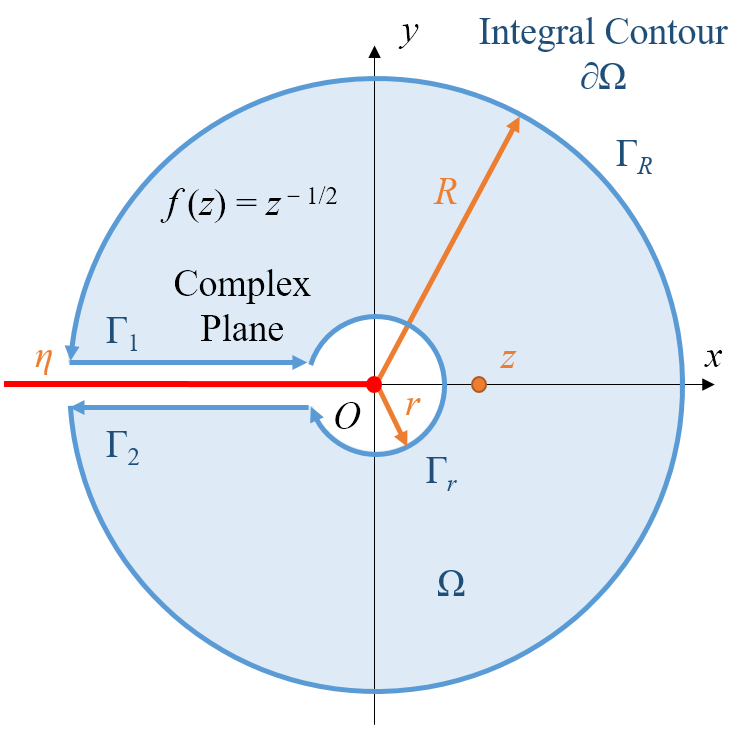

In [50]:
Image(filename="assets/integral_path.png", width=400)

该函数是一个多值函数，需要确定其单值支。如果我们仍然令 $z = r e^{i \theta}$，其中模长 $r \geqslant 0$，幅角 $\theta \in (-\pi, \pi]$。以及，

$$
f(z) = \frac{1}{\sqrt{z}} = \frac{1}{\sqrt{r}} e^{- i \frac{\theta}{2}}
$$

由于该函数存在单值支的问题，在 $\{ z = r e^{i \theta} | r = 0 \text{ or } \theta = \pi \}$ 下 (即上图的红色点线)，函数是不连续的。在 $r = 0$ 处是因为 $r^{-1/2}$ 处未定义；$\theta = \pi$ 处是因为举例来说，对于复平面上比较相邻的两个数 $\omega + i \eta, \omega - i \eta$ (实数轴上方与下方些微处的两点)，其中 $\omega < 0, \eta > 0$，则

$$
\lim_{\eta \rightarrow 0^+} \big( f(\omega + i \eta) - f(\omega - i \eta) \big) = - \pi
$$

因此显然在 $z = x < 0$ 点处是不可导的。对于其它位置，$f(x)$ 是全纯的，以及单值支的确切定义，在此不作说明。

接下来，我们讨论当 $z > 0$ 时，利用 Cauchy 积分定理计算 $f(z)$ 的值的问题。我们定义如上图所示的 $\partial \Omega = \Gamma_1 \cup \Gamma_r \cup \Gamma_2 \cup \Gamma_R$ 为下述有向曲线 (围道)：

$$
\begin{equation}\begin{aligned}
\Gamma_r &: \zeta(t) = r e^{- i t} && t \in [- \pi + \arccos(\eta / r), \pi - \arccos(\eta / r)] \\
\Gamma_R &: \zeta(t) = R e^{i t} && t \in [- \pi + \arccos(\eta / R), \pi - \arccos(\eta / R)] \\
\Gamma_1 &: \zeta(t) = \omega + i \eta, t = \omega && t \in (-R, -\sqrt{r^2 - \eta^2}) \\
\Gamma_2 &: \zeta(t) = \omega - i \eta, t = -\omega && t \in (-R, -\sqrt{r^2 - \eta^2}) \\
\end{aligned}\end{equation}
$$

其中，$0 < \eta < r < z < R$，且 $\eta, r$ 应尽可能小，$R$ 应尽可能大。

我们一根一根有向曲线分析。对于 $\Gamma_r$ 而言，

$$
\begin{align}
f(z) &\leftarrow \lim_{\eta < r \rightarrow 0^+} \left| \frac{1}{2 \pi i} \int_{\Gamma_r} \frac{f(\zeta)}{\zeta - z} \, \mathrm{d} \zeta \right| \\
&= \lim_{\eta < r \rightarrow 0^+} \left| \frac{1}{2 \pi i} \int_{- \pi + \arccos (\eta / r)}^{\pi - \arccos (\eta / r)} \frac{r^{-1/2} e^{it / 2}}{r e^{-it} - z} r (-i) e^{-it} \, \mathrm{d} t \right| \\
&= \lim_{\eta < r \rightarrow 0^+} \left| - \frac{1}{2 \pi} \frac{|r^{1/2} e^{- it / 2}|}{|r e^{-it} - z|} \int_{- \pi + \arccos (\eta / r)}^{\pi - \arccos (\eta / r)} \, \mathrm{d} t \right| \\
&\leqslant \lim_{\eta < r \rightarrow 0^+} \frac{1}{2 \pi} \frac{r^{1/2}}{r + z} (2 \pi - 2 \arccos(\eta / r)) \\
&< \lim_{r \rightarrow 0^+} \frac{r^{1/2}}{r + z} = 0
\end{align}
$$

对 $\Gamma_R$ 的分析也是非常类似的，可以证明其贡献也为零。

随后我们考虑 $\Gamma_1$ 上的积分：

$$
\begin{align}
f(z) &\leftarrow \lim_{\substack{\eta < r \rightarrow 0^+ \\ R \rightarrow + \infty}} \frac{1}{2 \pi i} \int_{\Gamma_1} \frac{f(\zeta)}{\zeta - z} \, \mathrm{d} \zeta \\
&= \lim_{\substack{\eta < r \rightarrow 0^+ \\ R \rightarrow + \infty}} \frac{1}{2 \pi i} \int_{-R}^{-\sqrt{r^2 - \eta^2}} \frac{(\omega + i \eta)^{-1/2}}{\omega + i \eta - z} \, \mathrm{d} \omega \\
&= \lim_{r \rightarrow 0^+} \frac{1}{2 \pi i} \int_{-\infty}^{-r} \frac{\omega^{-1/2}}{\omega - z} \, \mathrm{d} \omega
\end{align}
$$

如果我们令 $\omega = (i \tilde \omega)^2$，其中 $\tilde \omega > 0$，则 $\Gamma_1$ 的贡献值为

$$
\begin{align}
f(z) &\leftarrow \lim_{r \rightarrow 0^+} \frac{1}{2 \pi i} \int_{+\infty}^{\sqrt{r}} \frac{- i \tilde \omega^{-1}}{- \tilde \omega^2 - z} (- \tilde \omega) \, \mathrm{d} \tilde \omega = \lim_{r \rightarrow 0^+} \frac{1}{\pi} \int_{\sqrt{r}}^{+\infty} \frac{1}{\tilde \omega^2 + z} \, \mathrm{d} \tilde \omega \\
&= \frac{1}{\pi} \int_{0}^{+\infty} \frac{1}{\tilde \omega^2 + z} \, \mathrm{d} \tilde \omega
\end{align}
$$

对于 $\Gamma_2$ 的积分也是相同的。因此，最终有

$$
\begin{equation}
f(z) = \sqrt{\frac{1}{z}} = \frac{2}{\pi} \int_0^{+\infty} \frac{1}{\tilde \omega^2 + z} \, \mathrm{d} \tilde \omega \tag{18}
\end{equation}
$$

这看起来是一个非常平凡的结论，因为反向的推导是非常容易的：

$$
\int \frac{1}{\tilde \omega^2 + z} \, \mathrm{d} \tilde \omega = \sqrt{\frac{1}{z}} \arctan \sqrt{\frac{w^2}{z}} + C
$$

但它的意义在于，它可以对无法通过 Taylor (或者更广泛地 Laurent) 展开的函数 $z^{-1/2}$ (或者类似地，$z^{-1} \log z$)，通过积分的方式化为可展开的形式。

### $\mathbf{M}^{-1/2}$ 的积分展开

当引入矩阵函数后，我们按照式 (18)，对于任意实对称 **正定** 矩阵 $\mathbf{S}$，可以写为

$$
\begin{equation}
\mathbf{S}^{-1/2} = \frac{2}{\pi} \int_0^{+\infty} \frac{1}{\mathbf{S} + \tilde \omega^2 \mathbf{I}} \, \mathrm{d} \tilde \omega \tag{19}
\end{equation}
$$

这里我们引入了正定矩阵的要求，是因为之前我们的讨论中一直要求 $z > 0$，否则 $\Gamma_1$, $\Gamma_2$ 的围道积分就不成立了；因此到矩阵函数时，就要求本征值大于零。比如之前定义的 `S` 矩阵，就有一个小于零的本征值，因此不满足上式：

In [51]:
mat = np.zeros((5, 5))
for (omega, weight) in zip(ot, wt):
    mat += weight * 2 / np.pi * np.linalg.inv(S + omega**2 * np.eye(5))
np.allclose(mat, fractional_matrix_power(S, -0.5))

False

如果我们定义 (回顾上一节 $O(N^4)$ 程序实现部分的矩阵定义)

$$
\begin{align}
\mathbf{M} (\alpha) &= (\mathbf{A}^\alpha - \mathbf{B}^\alpha)^{1/2} (\mathbf{A}^\alpha + \mathbf{B}^\alpha) (\mathbf{A}^\alpha - \mathbf{B}^\alpha)^{1/2} \\
&= \mathbf{D}^{1/2} (\mathbf{D} + 2 \alpha \mathbf{V} \mathbf{V}^\dagger) \mathbf{D}^{1/2} \\
&= \mathbf{D}^2 + 2 \alpha \mathbf{D}^{1/2} \mathbf{V} \mathbf{V}^\dagger \mathbf{D}^{1/2}
\tag{20}
\end{align}
$$

对于 $\alpha = 1, 0$ 的情形，它就是正定的矩阵；因此满足式 (18)；我们拿 $\alpha = 1$ 的情形来验证：

In [52]:
mat = np.zeros((nocc*nvir, nocc*nvir))
for (omega, weight) in zip(ot, wt):
    mat += weight * 2 / np.pi * np.linalg.inv(M + omega**2 * np.eye(nocc*nvir))
np.allclose(mat, fractional_matrix_power(M, -0.5))

True

### 建立关于耦合常数 $\alpha$ 的积分

我们已经建立了从 $\mathbf{M}^{-1/2}$ 到 $\mathbf{M}$ 的联系，即将分数幂次转为整数幂次的积分展开。但我们记得相关能表达式为

$$
\begin{align}
E_\mathrm{c}^\mathsf{dRPA} [\rho]
&= \frac{1}{2} \mathrm{tr} \big( (\mathbf{M}^{1/2}) - \mathrm{tr} (\mathbf{A}^{\alpha = 1}) \big) \\
&= \frac{1}{2 \pi} \int_{0}^{+ \infty} \big( \log \det \big( \mathbf{1} - \mathbf{\Pi} (\tilde \omega_g) \big) + \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega_g) \big) \big) \, \mathrm{d} \tilde \omega
\end{align}
$$

因此我们还要建立某种联系，使得表达式中存在 $\log$。

这种联系的构建的方式与 Hellmann-Feynman 定理非常相似。我们首先表明，

$$
A_{ia, ia}^{\alpha = 1} = - \varepsilon_i + 2 \varepsilon_a + (ia|ia) = D_{ia} + 2 \sum_P V_{ia, P} V_{ia, P}
$$

因此，

$$
\mathrm{tr} (\mathbf{A}^{\alpha = 1}) = \mathrm{tr} (\mathbf{D} + 2 \mathbf{V} \mathbf{V}^\dagger) = \mathrm{tr} ((\mathbf{D}^2)^{1/2}) + 2 \mathrm{tr} (\mathbf{V}^\dagger \mathbf{V})
$$

我们留意到上一小节 $\mathbf{M}(\alpha)$ 的定义，知道 $\mathbf{M}(0) = \mathbf{D}^2, \mathbf{M}(1) = \mathbf{M}$，因此相关能可以写为

$$
\begin{align}
E_\mathrm{c}^\mathsf{dRPA} [\rho] &= \frac{1}{2} \big( \mathrm{tr} (\mathbf{M}^{1/2}) - \mathrm{tr} (\mathbf{A}^{\alpha = 1}) \big)
= \frac{1}{2} \big( \mathrm{tr} (\mathbf{M}(1)^{1/2}) - \mathrm{tr} (\mathbf{M}(0)^{1/2}) - 2 \mathrm{tr} (\mathbf{V}^\dagger \mathbf{V}) \big) \\
&= \frac{1}{2} \mathrm{tr} \left( \int_0^1 \frac{\mathrm{d} \mathbf{M} (\alpha)^{1/2}}{\mathrm{d} \alpha} \, \mathrm{d} \alpha \right) - \mathrm{tr} (\mathbf{V}^\dagger \mathbf{V}) \tag{21}
\end{align}
$$

我们回顾到在推导 $O(N^6)$ 计算量方法时，曾经使用 Hellmann-Feynman 定理，将 $\mathrm{d} \omega_n^\alpha / \mathrm{d} \alpha$ 转为 $\omega_n^{\alpha = 1} - \omega_n^{\alpha = 0}$，从而将不容易求取的关于 $\alpha$ 的积分转为可以通过类 CP-KS 方程可以求得的频率。但我们在 $O(N^4)$ 方法时，由于矩阵的导数比较容易求取，因此反而使用了相反的过程。

首先，我们处理矩阵的导数迹。现在对于矩阵及其本征分解式 $\mathbf{S} = \mathbf{F} \mathbf{\Lambda} \mathbf{F}^\dagger$，如果 $\mathbf{S}$ 可以看作关于 $\alpha$ 的矩阵变量，那么

$$
\begin{align}
\mathrm{tr} \left( \frac{\mathrm{d} \mathbf{S}}{\mathrm{d} \alpha} \right)
&= \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{F}}{\mathrm{d} \alpha} \mathbf{\Lambda} \mathbf{F}^\dagger + \mathbf{F} \frac{\mathrm{d} \mathbf{\Lambda}}{\mathrm{d} \alpha} \mathbf{F}^\dagger + \mathbf{F} \mathbf{\Lambda} \frac{\mathrm{d} \mathbf{F}^\dagger}{\mathrm{d} \alpha} \right) \\
&= \mathrm{tr} \left( \frac{\mathrm{d} (\mathbf{FF}^\dagger)}{\mathrm{d} \alpha} \mathbf{\Lambda} \right) + \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{\Lambda}}{\mathrm{d} \alpha} \right) \\
&= \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{\Lambda}}{\mathrm{d} \alpha} \right)
\end{align}
$$

类似地，

$$
\begin{align}
\mathrm{tr} \left( \frac{\mathrm{d} \mathbf{S}^{1/2}}{\mathrm{d} \alpha} \right)
= \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{\Lambda}^{1/2}}{\mathrm{d} \alpha} \right)
= \frac{1}{2} \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{\Lambda}}{\mathrm{d} \alpha} \mathbf{\Lambda}^{-1/2} \right)
= \frac{1}{2} \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{S}}{\mathrm{d} \alpha} \mathbf{S}^{-1/2} \right)
\end{align}
$$

同时注意到 $\mathbf{M} (\alpha)$ 的定义式 (20)，可知

$$
\frac{\mathrm{d} \mathbf{M(\alpha)}}{\mathbf{d} \alpha} = 4 \mathbf{D}^{1/2} \mathbf{V} \mathbf{V}^\dagger \mathbf{D}^{1/2}
$$

将 (19) 式代入可知，

$$
\begin{align}
&\quad \frac{1}{2} \mathrm{tr} \left( \int_0^1 \frac{\mathrm{d} \mathbf{M} (\alpha)^{1/2}}{\mathrm{d} \alpha} \, \mathrm{d} \alpha \right)
= \frac{1}{4} \int_0^1 \mathrm{tr} \left( \frac{\mathrm{d} \mathbf{M} (\alpha)}{\mathrm{d} \alpha} \mathbf{M} (\alpha)^{-1/2} \right) \, \mathrm{d} \alpha \\
&= \frac{1}{2 \pi} \int_{0}^{+\infty} \, \mathrm{d} \tilde \omega \int_0^1 \, \mathrm{d} \alpha \cdot \mathrm{tr} \left( 4 \mathbf{D}^{1/2} \mathbf{V} \mathbf{V}^\dagger \mathbf{D}^{1/2} (\mathbf{D}^2 + \tilde \omega^2 \mathbf{I} + 4 \alpha \mathbf{D}^{1/2} \mathbf{V} \mathbf{V}^\dagger \mathbf{D}^{1/2})^{-1} \right)
\end{align}
$$

如果我们令对称矩阵 (对比式 (16) 所定义的 $\mathbf{\Pi} (\tilde \omega)$)

$$
\begin{equation}
\tilde{\mathbf{\Pi}} (\tilde \omega) = - 4 (\mathbf{D} + \tilde \omega^2 \mathbf{I})^{-1/2} \mathbf{D}^{1/2} \mathbf{V} \mathbf{V}^\dagger \mathbf{D}^{1/2} (\mathbf{D} + \tilde \omega^2 \mathbf{I})^{-1/2} \tag{22}
\end{equation}
$$

那么，

$$
\frac{1}{2} \mathrm{tr} \left( \int_0^1 \frac{\mathrm{d} \mathbf{M} (\alpha)^{1/2}}{\mathrm{d} \alpha} \, \mathrm{d} \alpha \right)
= - \frac{1}{2 \pi} \int_{0}^{+\infty} \, \mathrm{d} \tilde \omega \int_0^1 \, \mathrm{d} \alpha \cdot \mathrm{tr} \left( \tilde{\mathbf{\Pi}} (\tilde \omega) (\mathbf{I} - \alpha \tilde{\mathbf{\Pi}} (\tilde \omega) )^{-1} \right)
$$

如果我们现在令

$$
\tilde f(x) = \frac{x}{1 - \alpha x}
$$

有必要指出，

$$
\begin{align}
\tilde f(\mathbf{S}) &= \mathbf{F} \tilde f(\mathbf{\Lambda}) \mathbf{F}^\dagger
= \mathbf{F} \mathbf{\Lambda} (\mathbf{I} - \alpha \mathbf{\Lambda})^{-1} \mathbf{F}^\dagger \\
&= \mathbf{F} \mathbf{\Lambda} \mathbf{F}^\dagger (\mathbf{I} - \alpha \mathbf{F}^\dagger \mathbf{\Lambda} \mathbf{F})^{-1} \\
&\neq \mathbf{S} (\mathbf{I} - \alpha \mathbf{S})^{-1}
\end{align}
$$

但根据 $\mathbf{F}$ 作为正交矩阵的性质，容易推知

$$
\mathrm{tr} \big( \tilde f (\mathbf{S}) \big) = \mathrm{tr} \big( \mathbf{S} (\mathbf{I} - \alpha \mathbf{S})^{-1} \big)
$$

同时，我们注意到

$$
\int_0^1 \frac{x}{1 - \alpha x} \, \mathrm{d} \alpha = - \log (1 - x) , \quad x < 1
$$

同时利用到式 (17) 的 $\mathrm{tr} \log = \log \det$ 的关系式，可知

$$
\begin{align}
&\quad \frac{1}{2} \mathrm{tr} \left( \int_0^1 \frac{\mathrm{d} \mathbf{M} (\alpha)^{1/2}}{\mathrm{d} \alpha} \, \mathrm{d} \alpha \right)
= \frac{1}{2 \pi} \int_{0}^{+\infty} \, \mathrm{d} \tilde \omega \cdot \mathrm{tr} \left( \int_0^1 \tilde f(\tilde{\mathbf{\Pi}} (\tilde \omega)) \, \mathrm{d} \alpha \right) \\
&= \frac{1}{2 \pi} \int_{0}^{+\infty} \mathrm{tr} \log (\mathbf{I} - \tilde{\mathbf{\Pi}}(\tilde \omega)) \, \mathrm{d} \tilde \omega
= \frac{1}{2 \pi} \int_{0}^{+\infty} \log \det (\mathbf{I} - \tilde{\mathbf{\Pi}}(\tilde \omega)) \, \mathrm{d} \tilde \omega
\end{align}
$$

### 最终结果的导出

最后我们作收尾工作。首先，依据下述结论 (<cite data-cite="Yao-Wu.Fudan.2008">姚慕生，高等代数学</cite> 6.1 节习题 9)：

$$
\det (\lambda \mathbf{I} - \mathbf{X} \mathbf{Y}) = \lambda^{m - n} \det (\lambda \mathbf{I} - \mathbf{Y} \mathbf{X})
$$

上式中，$\mathbf{X} \in \mathbb{R}^{m \times n}, \mathbf{Y} \in \mathbb{R}^{n \times m}, m \geqslant n$，两处 $\mathbf{I}$ 是不同的。以此可以表明，$\mathbf{XY}$ 的本征值与 $\mathbf{YX}$ 的本征值“相同”，即 $\mathbf{XY}$ 有 $n$ 个本征值是 $\mathbf{YX}$ 的本征值，而剩下的 $m - n$ 个本征值是 0。

套用在我们目前的问题中，则表现为 $\tilde{\mathbf{\Pi}} (\tilde \omega)$ 与 $\mathbf{\Pi} (\tilde \omega)$ 在相同的 $\tilde \omega$ 情况下，$n_\mathrm{aux}$ 本征值相同；其它 $n_\mathrm{occ} n_\mathrm{vir} - n_\mathrm{aux}$ 个本征值则为零。这可以很容易地令 $\mathbf{X} = \mathbf{Y}^\dagger = (\mathbf{D} + \tilde \omega^2 \mathbf{I})^{-1/2} \mathbf{D}^{1/2} \mathbf{V}$ 来说明。

也因此，$\mathbf{I} - \tilde{\mathbf{\Pi}} (\tilde \omega)$ 与 $\mathbf{\Pi} (\tilde \omega)$ 的 $n_\mathrm{aux}$ 本征值相同，其它 $n_\mathrm{occ} n_\mathrm{vir} - n_\mathrm{aux}$ 个本征值则为 1；从而这些本征值的乘积 (即行列式值) 相等。因此，

$$
\log \det (\mathbf{I} - \tilde{\mathbf{\Pi}}(\tilde \omega)) = \log \det (\mathbf{I} - {\mathbf{\Pi}}(\tilde \omega))
$$

另一个需要证明的问题是式 (21) 中出现的

$$
\mathrm{tr} (\mathbf{V}^\dagger \mathbf{V}) = - \frac{1}{2 \pi} \int_{0}^{+ \infty} \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega_g) \big) \, \mathrm{d} \tilde \omega
$$

这只需要插入

$$
\mathbf{D}^{-1} = (\mathbf{D}^2)^{-1/2} = \frac{2}{\pi} \int_0^{+\infty} \frac{1}{\mathbf{D}^2 + \tilde \omega^2 \mathbf{I}} \, \mathrm{d} \tilde \omega
$$

那么

$$
\begin{align}
\mathrm{tr} (\mathbf{V}^\dagger \mathbf{V}) &= \mathrm{tr} (\mathbf{V}^\dagger \mathbf{D}^{1/2} \mathbf{D}^{-1} \mathbf{D}^{1/2} \mathbf{V}) \\
&= - \frac{1}{2 \pi} \int_0^{+\infty} \mathrm{tr} \left( - \mathbf{V}^\dagger \mathbf{D}^{1/2} \frac{4}{\mathbf{D}^2 + \tilde \omega^2 \mathbf{I}} \mathbf{D}^{1/2} \mathbf{V} \right) \, \mathrm{d} \tilde \omega \\
&= - \frac{1}{2 \pi} \int_{0}^{+ \infty} \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega_g) \big) \, \mathrm{d} \tilde \omega
\end{align}
$$

至此，$O(N^4)$ 与 $O(N^6)$ 两种计算复杂度表达式

$$
E_\mathrm{c}^\mathsf{dRPA} [\rho] = \frac{1}{2} \mathrm{tr} (\mathbf{M}^{1/2}) - \mathrm{tr} (\mathbf{A}^{\alpha = 1}) \big)
= \frac{1}{2 \pi} \int_{0}^{+ \infty} \big( \log \det \big( \mathbf{1} - \mathbf{\Pi} (\tilde \omega_g) \big) + \mathrm{tr} \big( \mathbf{\Pi} (\tilde \omega_g) \big) \big) \, \mathrm{d} \tilde \omega
$$

的等价性证明就完成了。

## 参考文献